https://quantscience.io/newsletter

https://github.com/quant-science/sunday-quant-scientist/blob/main/QS007-ML-in-finance/01_ml_trend_detection.py?ck_subscriber_id=3153325785

In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

# pd.set_option('display.max_rows', None)
# pd.set_option("display.max_columns", None)
# !pip install yfinance

import yfinance as yf

### My Stocks new 52H

In [ ]:
# historical data for sepecif dates

tickers =  list(NIFTY_50[1]['Symbol'])

# tickers = ['HAL','KEI','TRENT','KIRLOSBROS','KPITTECH','VBL','SOLARINDS',	'JINDALSTEL','SIEMENS']
start = '2015-01-01'
end = '2025-06-05'

tickers = [i+".NS" for i in tickers]
price = yf.download(tickers, start, end)['Close']

In [ ]:
ticker = yf.Ticker("HAL.NS")
info = ticker.info

high_52week = info.get("fiftyTwoWeekHigh", None)
print(f"52-Week High from info: {high_52week}")


In [ ]:
import yfinance as yf
import pandas as pd

# Download historical data (more than 1 year to allow 252-day rolling)
data = yf.download(tickers, start="2015-01-01", interval="1d", group_by="ticker", auto_adjust=True)

# Dictionary to collect stale_count per ticker
stale_dict = {}

for ticker in tickers:
    df = data[ticker][['High']].dropna()

    # Rolling 252-day high
    df['Rolling_52H'] = df['High'].rolling(window=252, min_periods=1).max()

    # Flag where 52H is same as previous day
    df['Same_As_Previous'] = df['Rolling_52H'] == df['Rolling_52H'].shift(1)

    # Count consecutive days of unchanged 52H
    df['Stale_Count'] = df['Same_As_Previous'].astype(int).groupby((df['Same_As_Previous'] != df['Same_As_Previous'].shift()).cumsum()).cumsum()

    # Save the Stale_Count series for this ticker
    stale_dict[ticker] = df['Stale_Count']

# Combine all into one DataFrame
stale_df = pd.DataFrame(stale_dict)

# Optional: drop rows where all values are NaN
stale_df.dropna(how='all', inplace=True)

# Show sample
stale_df

In [ ]:
# Step 1: Ensure stale_df is available
# (from previous code, where date is the index)

# Step 2: Add a 'Month' column (format: YYYY-MM)
# stale_df['Month'] = stale_df.index.to_period('M').astype(str)

# Step 3: Unpivot the DataFrame to long format
stale_long = stale_df.reset_index().melt(id_vars=['Date'], 
                                         var_name='Ticker', 
                                         value_name='Stale_Count')

# Step 4: Create pivot table — index = Month, columns = Ticker, values = max stale count
pivot_df = stale_long.pivot_table(index='Date', 
                                   columns='Ticker', 
                                   values='Stale_Count', 
                                   aggfunc='max')

# Optional: Sort by month
pivot_df.sort_index(inplace=True)

# Show result
pivot_df

In [ ]:
pivot_df.max().sort_values()

In [ ]:
stale_df.max().sort_values()

In [ ]:
# Dictionary to hold result
max_stale_info = {}

# Loop over each ticker column
for ticker in stale_df.columns:  # skip 'Month' if it's in stale_df
    max_val = stale_df[ticker].max()
    max_date = stale_df[stale_df[ticker] == max_val].index[0]  # first date it occurred
    max_stale_info[ticker] = {"Max_Stale_Days": max_val, "Date": max_date}

# Convert to DataFrame for easy viewing
max_stale_df = pd.DataFrame(max_stale_info).T  # transpose to get tickers as rows

# Sort by Max_Stale_Days
max_stale_df_sorted = max_stale_df.sort_values(by="Max_Stale_Days")

# Show result
max_stale_df_sorted


In [ ]:
pivot_df.mean().sort_values()

In [ ]:
stale_df.mean().sort_values()

In [ ]:
import matplotlib.pyplot as plt

# Plotting the pivot_df
plt.figure(figsize=(12, 6))

for ticker in pivot_df.columns:
    plt.plot(pivot_df.index, pivot_df[ticker], marker='o', label=ticker)

plt.title("Monthly Max Stale Count (52-Week High Not Updated)")
plt.xlabel("Month")
plt.ylabel("Max Stale Count (Days)")
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(title="Ticker", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


### Outliers

In [ ]:
# We are trying to get a base date where most of the tickers are starting thire journey in similar way from lowest point. 
# In 2020 most of stocks made low, but we can not consider it because it was outlier event
# In 2022 most of stocks made low, we can condider this year but we are not sure about date
# So first we will download the data from 2021 high point date As per the nifty graph
# Then we will min max normalize the data, so in 2022 most of the stock will have 0 and in 2025 most of them hanve 1.
# We will find the min std of 2022, this the date where most of the stock are at low poit.
# We will filter data from that day, means that date will be our base date.

In [ ]:
# We can make drive below type of data from stock price data 
# Min Max Normailize
# Change percentage data
# Cumulative Change percentange data
# 

In [ ]:
import yfinance as yf
from datetime import date
import pandas as pd

NIFTY_50 = pd.read_html(r"https://en.wikipedia.org/wiki/NIFTY_50")
NIFTY_N50 = pd.read_html(r"https://en.wikipedia.org/wiki/NIFTY_Next_50")
NIFTY_500 = pd.read_html(r"https://en.wikipedia.org/wiki/NIFTY_500")

tickers_NIFTY_50 = list(NIFTY_50[1]['Symbol'])
tickers_NIFTY_N100 = list(NIFTY_N50[2]['Symbol'])
tickers_NIFTY_100 = tickers_NIFTY_50+tickers_NIFTY_N100
tickers_NIFTY_500 = list(NIFTY_500[4].iloc[1:,3])              

tickers =  tickers_NIFTY_100
tickers = [i + ".NS" for i in tickers]

start = "2020-01-01"
# end = "2022-07-01"
end = date.today().strftime("%Y-%m-%d")
data_nifty = yf.download(tickers, start, end, interval="1d", auto_adjust=True)['Close']

In [ ]:
data_nifty.columns

In [70]:
data = data_nifty.copy()

# excluded_columns = ["RELIANCE.NS", "HDFCBANK.NS", "ICICIBANK.NS", "INFY.NS", "TCS.NS", "ITC.NS", "LT.NS", "SBIN.NS", "BHARTIARTL.NS", "KOTAKBANK.NS"]
# data =data.drop(columns=excluded_columns).copy()
# data = data[excluded_columns]

# normalized_df = pd.DataFrame()
# for ticker in data.columns:
#     df = data[ticker].dropna()
#     all_time_min = df.min()
#     all_time_max = df.max()
#     df[f'{ticker}_Normalized'] = (df - all_time_min) / (all_time_max - all_time_min)
#     normalized_df[ticker] = df[f'{ticker}_Normalized']

# Simpler version of above code
normalized_df = data.apply(lambda x: (x - x.min()) / (x.max() - x.min()))

NameError: name 'data_nifty' is not defined

In [ ]:
# normalized_df = normalized_df.dropna(axis=1)

In [ ]:
# normalized_df['Month'] = normalized_df.index.to_period('M').astype(str)
# normalized_df.std(axis=1).sort_values().head(50)

daily_std = normalized_df.std(axis=1)
std_df = pd.DataFrame(daily_std,columns=['std'])
std_df['Year'] = std_df.index.year
min_std_dates = std_df.groupby('Year')['std'].idxmin()   # returns date (index) where std is min
min_std_values = std_df.loc[min_std_dates].round(2).reset_index()
min_std_values

In [ ]:
normalized_df

In [ ]:
# Nifty 100 top 10

df = pd.DataFrame()
df['sum'] = normalized_df.sum(axis=1)/10
df['std'] = normalized_df.std(axis=1)
for col in df:
    plt.plot(df[col])

In [ ]:
# Nifty 100 next 90

df = pd.DataFrame()
df['sum'] = normalized_df.sum(axis=1)/90
df['std'] = normalized_df.std(axis=1)
for col in df:
    plt.plot(df[col])

In [ ]:
# So we will consider 2022-06-17 as the base date and 2024-09-16 as max date
# And we will consider base price of tickers from that date
# Now again we will filter the data and normalize it from that date
# and handle columns with NaN, otherwise can't calculate std

In [ ]:
data = data_nifty[(data_nifty.index>='2022-06-17') & (data_nifty.index<='2024-09-16')].copy()

normalized_df = pd.DataFrame()
for ticker in tickers:
    df = data[ticker].dropna()
    all_time_min = df.min()
    all_time_max = df.max()
    df[f'{ticker}_Normalized'] = (df - all_time_min) / (all_time_max - all_time_min)
    normalized_df[ticker] = df[f'{ticker}_Normalized']

In [ ]:
normalized_df.columns[normalized_df.isna().any()]

In [ ]:
normalized_df = normalized_df.dropna(axis=1)

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 8))

data = normalized_df
# Plot all stocks' DiffPct_vs_MA25 columns (multiple lines)
for col in data.columns:
    plt.plot(data.index, data[col], label=col, alpha=0.6)

plt.title("Trend of % Difference Between Price and MA25 for Stocks")
plt.xlabel("Date")
plt.ylabel("Percentage Difference (%)")
plt.legend(loc='upper left', bbox_to_anchor=(1,1), fontsize='small', ncol=1)
plt.tight_layout()
plt.show()

In [ ]:
# just to see outliers
base_day_prices = normalized_df.iloc[1, :]
sns.histplot(base_day_prices, kde=True, bins=100)

In [ ]:
# just to see outliers
base_day_prices = normalized_df.iloc[1, :]
plt.figure(figsize=(8, 4))
sns.boxplot(x=base_day_prices)

In [ ]:
# When all were making low they were up but after that they made more low (cap curve)

from scipy.stats import zscore

base_day_prices = normalized_df.iloc[0, :]

z_scores = zscore(base_day_prices)
outliers_df = pd.DataFrame({
    'Normalized_Price': base_day_prices,
    'Z_Score': z_scores
})

threshold = 1
outliers_base_day = outliers_df[(outliers_df['Z_Score']) > threshold]
outliers_base_day.sort_values(by='Normalized_Price')

In [ ]:
# When all were making up they made very up before and now they are very down (cap curve)

from scipy.stats import zscore

max_day_prices = normalized_df.iloc[-1, :]

z_scores = zscore(max_day_prices)
outliers_df = pd.DataFrame({
    'Normalized_Price': max_day_prices,
    'Z_Score': z_scores
})

threshold = -1.5
outliers_max_day = outliers_df[(outliers_df['Z_Score']) < threshold]
outliers_max_day.sort_values(by='Normalized_Price')

In [ ]:
outlier_tickers = outliers_base_day.index.to_list()+outliers_max_day.index.to_list()

In [ ]:
A = outliers_base_day[outliers_base_day['Z_Score']>1].index.to_list()
B = outliers_max_day[outliers_max_day['Z_Score']<-1].index.to_list()
list(set(A) & set(B)) 
# This outlier made bowl curve

In [ ]:
filtered_df = normalized_df.drop(columns=outlier_tickers)

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 8))

data = filtered_df
# Plot all stocks' DiffPct_vs_MA25 columns (multiple lines)
for col in data.columns:
    plt.plot(data.index, data[col], label=col, alpha=0.6)

plt.title("Trend of % Difference Between Price and MA25 for Stocks")
plt.xlabel("Date")
plt.ylabel("Percentage Difference (%)")
plt.legend(loc='upper left', bbox_to_anchor=(1,1), fontsize='small', ncol=1)
# plt.tight_layout()
plt.show()

In [ ]:
### Correlation and Clustering

In [ ]:
filtered_df.drop(columns=['TCS.NS','DMART.NS'], inplace=True)

In [ ]:
correlation_matrix = filtered_df.corr()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Stock Price Correlation Heatmap")
plt.tight_layout()
plt.show()


In [ ]:
# Unstack and filter pairs
corr_pairs = correlation_matrix.unstack().sort_values(ascending=False)

# Remove self-correlations (value == 1)
corr_pairs = corr_pairs[corr_pairs < 1]

# Filter top N most positively correlated pairs
top_corr = corr_pairs[corr_pairs > 0.5].drop_duplicates()
top_corr.head(50)

In [ ]:
neg_corr = corr_pairs[corr_pairs < 0]
neg_corr.head(10)

In [ ]:
from scipy.cluster.hierarchy import linkage, dendrogram

import matplotlib.pyplot as plt


# Create linkage matrix
link = linkage(correlation_matrix, method='ward')

# Plot dendrogram
plt.figure(figsize=(12, 8))
dendrogram(link, labels=correlation_matrix.columns, leaf_rotation=90)
plt.title('Stock Clustering by Correlation')
plt.tight_layout()
plt.show()

### Clustering

In [ ]:
data = data_nifty[(data_nifty.index>='2022-06-17') & (data_nifty.index<='2024-09-16')].dropna(axis=1).copy()

In [ ]:
# Min Max normalized 

filtered_df = normalized_df.drop(columns=outlier_tickers)

In [ ]:
# pct diff cumulative return 

returns = data.pct_change().replace([np.inf, -np.inf], np.nan).cumsum().dropna()
returns_corr = returns.corr()

# Then re-do the heatmap or analysis

In [ ]:
# Overall return from min date

returns = ((data / data.iloc[0]) - 1)*100
returns_corr = returns.corr()

In [ ]:
from scipy.cluster.hierarchy import linkage, dendrogram

import matplotlib.pyplot as plt

correlation_matrix = returns_corr

# Create linkage matrix
link = linkage(correlation_matrix, method='ward')

# Plot dendrogram
plt.figure(figsize=(12, 8))
dendrogram(link, labels=correlation_matrix.columns, leaf_rotation=90)
plt.title('Stock Clustering by Correlation')
plt.tight_layout()
plt.show()

In [ ]:
from scipy.cluster.hierarchy import fcluster

t=5

# Cut the dendrogram at a chosen distance threshold (tune t)
cluster_labels = fcluster(link, t, criterion='distance')

# Map each stock to its cluster
stock_clusters = pd.DataFrame({
    'Stock': correlation_matrix.columns,
    'Cluster': cluster_labels
}).set_index('Stock')

stock_clusters.sort_values(by='Cluster')


In [ ]:
grouped_stocks = stock_clusters.groupby('Cluster').groups

for cluster_id, stocks in grouped_stocks.items():
    print(f"\n📦 Cluster {cluster_id}: {list(stocks)}")

In [ ]:
[print(i[:-3]) for i in list(grouped_stocks[2])]

In [ ]:
# Insights:
# Cluster 1 : Neech chale gaye, uthe nahi
# Cluster 2 : Hamehsa Uthte hi gaye
# Cluster 3 : Neeche chale gaye, uth gaye

for cluster_id, stocks in grouped_stocks.items():
    plt.figure(figsize=(10, 5))
    for stock in stocks:
        # plt.plot(filtered_df[stock], label=stock)
        plt.plot(returns[stock], label=stock)
    
    plt.title(f"Stock Prices for Cluster {cluster_id}")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.grid(True)

    # Place legend outside
    plt.legend(title="Stock", bbox_to_anchor=(1.05, 1), loc='upper left')
    # plt.tight_layout()
    plt.show()


In [ ]:
# It give best view (pct diff - panalize outliers)

for cluster_id, stocks in grouped_stocks.items():
    plt.figure(figsize=(10, 5))
    for stock in stocks:
        # plt.plot(filtered_df[stock], label=stock)
        plt.plot(returns[stock], label=stock)
    
    plt.title(f"Stock Prices for Cluster {cluster_id}")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.grid(True)

    # Place legend outside
    plt.legend(title="Stock", bbox_to_anchor=(1.05, 1), loc='upper left')
    # plt.tight_layout()
    plt.show()


In [ ]:
returns.iloc[-1].sort_values()

In [ ]:
# Normalized me return capture nahi ho raha, Cluster1 and Cluster3 same lag rahe hain
# Normalized me pattern capter dikh sakta hai, means we can see which stocks follow market. but can't see how much.

for cluster_id, stocks in grouped_stocks.items():
    plt.plot(normalized_df[stocks])
    plt.show()

In [ ]:
for cluster_id, stocks in grouped_stocks.items():
    cluster_corr = normalized_df[stocks].corr()
    print(f"\n📊 Correlation Matrix - Cluster {cluster_id}:\n", cluster_corr)
    # sns.heatmap(cluster_corr, annot=True, fmt=".2f", cmap="coolwarm", center=0)

In [ ]:
import matplotlib.pyplot as plt

# returns = data.pct_change().dropna()  # Ensure this if not already done
# returns = data_pct_diff.copy()  # You already have it as percentage difference

plt.figure(figsize=(12, 6))

for cluster_id, stocks in grouped_stocks.items():
    cluster_returns = returns[stocks].mean(axis=1)  # Average return of all stocks in the cluster
    plt.plot(cluster_returns.cumsum(), label=f"Cluster {cluster_id}")

plt.title("📈 Cumulative Returns of Stock Clusters")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend(title="Cluster")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
plt.plot(filtered_df['TCS.NS'].pct_change())

# Sirt ek stock me problem hone ke karn pouri clustering galat ho rahi thi

In [ ]:
[print(i[:-3]) for i in list(grouped_stocks[3])]

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 8))

data = returns[['BAJAJFINSV.NS','INDUSINDBK.NS','ITC.NS','DABUR.NS','LTIM.NS','ASIANPAINT.NS', 'HDFCBANK.NS', 'HINDUNILVR.NS']]

# Plot all stocks' DiffPct_vs_MA25 columns (multiple lines)
for col in data.columns:
    plt.plot(data.index, data[col].cumsum(), label=col, alpha=0.6)

plt.title("Trend of % Difference Between Price and MA25 for Stocks")
plt.xlabel("Date")
plt.ylabel("Percentage Difference (%)")
plt.legend(loc='upper left', bbox_to_anchor=(1,1), fontsize='small', ncol=1)
# plt.tight_layout()
plt.show()

In [ ]:
# Volatility

import matplotlib.pyplot as plt

plt.figure(figsize=(15, 8))

data = returns[['BAJAJFINSV.NS','INDUSINDBK.NS','ITC.NS','DABUR.NS','LTIM.NS','ASIANPAINT.NS', 'HDFCBANK.NS', 'HINDUNILVR.NS']]

# Plot all stocks' DiffPct_vs_MA25 columns (multiple lines)
for col in data.columns:
    plt.plot(data.index, data[col], label=col, alpha=0.6)

plt.title("Trend of % Difference Between Price and MA25 for Stocks")
plt.xlabel("Date")
plt.ylabel("Percentage Difference (%)")
plt.legend(loc='upper left', bbox_to_anchor=(1,1), fontsize='small', ncol=1)
# plt.tight_layout()
plt.show()

In [ ]:
rolling_corr = filtered_df['VBL.NS'].pct_change().rolling(30).corr(filtered_df['GAIL.NS'].pct_change())
plt.plot(rolling_corr)

In [ ]:
# If you have sector info
stock_info_df = pd.DataFrame({
    'Stock': correlation_matrix.columns,
    'Cluster': cluster_labels,
    'Sector': sectors_list  # e.g., fetched from yfinance or other source
}).set_index('Stock')

print(stock_info_df.sort_values(by='Cluster'))


In [ ]:
vol_df = returns.std()

for cluster_id, stocks in grouped_stocks.items():
    avg_vol = vol_df[stocks].mean()
    print(f"Cluster {cluster_id} - Avg Volatility: {avg_vol:.4f}")

In [ ]:
for cluster_id, stocks in grouped_stocks.items():
    avg_return = returns.mean()[stocks].mean()
    print(f"Cluster {cluster_id} - Avg Daily Return: {avg_return:.4f}")

In [ ]:
import seaborn as sns

for cluster_id, stocks in grouped_stocks.items():
    plt.figure(figsize=(6, 4))
    sns.heatmap(returns[stocks].corr(), annot=False, cmap='coolwarm')
    plt.title(f"Correlation Heatmap - Cluster {cluster_id}")
    plt.show()

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np

# returns = data.pct_change().dropna()
scaled_returns = StandardScaler().fit_transform(returns.replace([np.inf, -np.inf], 1).T)

pca = PCA(n_components=2)
pca_components = pca.fit_transform(scaled_returns)

# Create DataFrame for plotting
pca_df = pd.DataFrame(pca_components, columns=['PC1', 'PC2'])
pca_df['Cluster'] = cluster_labels
pca_df['Stock'] = returns.columns

# Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Cluster', style='Cluster')
plt.title('PCA - Stock Clusters')
plt.show()


### Market Analysis

In [ ]:
data = data_nifty[(data_nifty.index>='2019-06-17') & (data_nifty.index<='2024-09-16')].dropna(axis=1).copy()

In [ ]:
# pct diff cumulative return 

pct_change = data.pct_change().replace([np.inf, -np.inf], np.nan).fillna(0)

In [ ]:
pct_change

In [ ]:
# Define z-score threshold
z_thresh = 2.0

# Function to replace outliers in each row
def replace_outliers_with_row_mean(row):
    z_scores = zscore(row, nan_policy='omit')
    outliers = np.abs(z_scores) > z_thresh
    mean_value = row[~outliers].mean()
    row[outliers] = mean_value
    return row

# Apply row-wise
cleaned_df = pct_change.apply(replace_outliers_with_row_mean, axis=1)

In [ ]:
plt.plot(pct_change.mean(axis=1))

In [ ]:
pct_change.min(axis=0).sort_values()

In [ ]:
z_thresh = 2.0
z_scores = zscore(pct_change.mean(axis=1), nan_policy='omit')
outliers = np.abs(z_scores) > z_thresh

In [ ]:
pct_change[outliers]

In [ ]:
daily_std = normalized_df.std(axis=1)
std_df = pd.DataFrame(daily_std,columns=['std'])
std_df['Year'] = std_df.index.year
min_std_dates = std_df.groupby('Year')['std'].idxmin()   # returns date (index) where std is min
min_std_values = std_df.loc[min_std_dates].round(2).reset_index()
min_std_values

In [ ]:
std_df['Year'].value_counts()

In [ ]:
daily_std = pct_change.mean(axis=1)
std_df = pd.DataFrame(daily_std,columns=['std'])
std_df['Year'] = std_df.index.year
# std_df['Month'] = std_df.index.month
min_std_dates = std_df.groupby(['Year'])['std'].idxmin()   # returns date (index) where std is min
min_std_values = std_df.loc[min_std_dates].round(5)
min_std_values

In [ ]:
daily_std = nifty100[[( 'Close', '^CNX100')]].mean(axis=1)
# daily_std = pct_change.mean(axis=1)
std_df = pd.DataFrame(daily_std,columns=['std'])
std_df['Year'] = std_df.index.year
# std_df['Month'] = std_df.index.month
min_std_dates = std_df.groupby(['Year'])['std'].idxmin()   # returns date (index) where std is min
min_std_values = std_df.loc[min_std_dates].round(5)
min_std_values

In [ ]:
daily_std = pct_change.mean(axis=1)
std_df = pd.DataFrame(daily_std,columns=['std'])
std_df['Year'] = std_df.index.year
std_df['Month'] = std_df.index.month
min_std_dates = std_df.groupby(['Year','Month'])['std'].idxmin()   # returns date (index) where std is min
min_std_values = std_df.loc[min_std_dates].round(5)
min_std_values

In [ ]:
plt.plot(min_std_values['std'])

In [ ]:
daily_std[(daily_std.index>'2022-01-01') & (daily_std.index<'2022-06-01')].sort_values().tail(50

In [ ]:
data = data_nifty[(data_nifty.index>='2019-06-17') & (data_nifty.index<='2025-09-16')].dropna(axis=1).copy()
excluded_columns = ["RELIANCE.NS", "HDFCBANK.NS", "ICICIBANK.NS", "INFY.NS", "TCS.NS",
                    "ITC.NS", "LT.NS", "SBIN.NS", "BHARTIARTL.NS", "KOTAKBANK.NS"]
# data = data.drop(columns=excluded_columns)

pct_change = data.pct_change().replace([np.inf, -np.inf], np.nan).fillna(0)
plt.plot(pct_change.cumsum().mean(axis=1))

In [ ]:
plt.plot(daily_std)

In [ ]:
plt.plot(daily_std)

In [ ]:
nifty100 = yf.download('^CNX100', start='2020-01-01', end='2025-04-30')

In [ ]:
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd

# Download NIFTY 100 data (symbol for NSE is ^CNX100)
nifty100 = yf.download('^CNX100', start='2022-04-01', end='2022-08-30')

# Plot closing price trend
plt.figure(figsize=(12, 6))
plt.plot(nifty100['Close'], label='NIFTY 100 Closing Price', color='blue')
plt.title('NIFTY 100 Index Trend (2020 - 2025)', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Index Level')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd

# Download NIFTY 100 data (symbol for NSE is ^CNX100)
nifty100 = yf.download('^CNX100', start='2020-01-01', end='2026-04-16')

# Plot closing price trend
plt.figure(figsize=(12, 6))
plt.plot(nifty100['Close'], label='NIFTY 100 Closing Price', color='blue')
plt.title('NIFTY 100 Index Trend (2020 - 2025)', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Index Level')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Define top 10 stocks of Nifty 100 (by market cap or weight)
top_10_tickers = [
    "RELIANCE.NS", "HDFCBANK.NS", "ICICIBANK.NS", "INFY.NS", "TCS.NS",
    "ITC.NS", "LT.NS", "SBIN.NS", "BHARTIARTL.NS", "KOTAKBANK.NS"
]

tickers =  tickers_NIFTY_100
tickers = [i + ".NS" for i in tickers]

# Step 2: Download historical data
# data = yf.download(tickers, start='2024-08-01', end='2024-10-16')['Close']

# Step 3: Normalize prices to start from 100 for comparison
returns = data[[
    "RELIANCE.NS", "HDFCBANK.NS", "ICICIBANK.NS", "INFY.NS", "TCS.NS",
    "ITC.NS", "LT.NS", "SBIN.NS", "BHARTIARTL.NS", "KOTAKBANK.NS"
]].pct_change().replace([np.inf, -np.inf], np.nan)

import matplotlib.pyplot as plt

plt.figure(figsize=(15, 8))

# data = returns[['BAJAJFINSV.NS','INDUSINDBK.NS','ITC.NS','DABUR.NS','LTIM.NS','ASIANPAINT.NS', 'HDFCBANK.NS', 'HINDUNILVR.NS']]

# Plot all stocks' DiffPct_vs_MA25 columns (multiple lines)
for col in returns.columns:
    plt.plot(returns.index, returns[col], label=col, alpha=0.6)

plt.title("Trend of % Difference Between Price and MA25 for Stocks")
plt.xlabel("Date")
plt.ylabel("Percentage Difference (%)")
plt.legend(loc='upper left', bbox_to_anchor=(1,1), fontsize='small', ncol=1)
# plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Example: prices DataFrame
# Rows = dates, Columns = stock tickers
# prices = pd.read_csv('your_stock_price_data.csv', index_col='Date', parse_dates=True)

# Compute 25-day moving average (M25)

prices = data.copy()
m25 = prices.rolling(window=180).mean()

# Create boolean DataFrame: True if price < M25
below_m25 = prices > m25

# Count how many stocks are below M25 each day
count_below_m25 = below_m25.sum(axis=1)

# Plot
plt.figure(figsize=(12, 6))
plt.plot(count_below_m25, label='Stocks below M25')
plt.title('Count of Stocks Below 25-Day Moving Average')
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Example: prices DataFrame
# Rows = dates, Columns = stock tickers
# prices = pd.read_csv('your_stock_price_data.csv', index_col='Date', parse_dates=True)

# Compute 25-day moving average (M25)

prices = yf.download('^CNX100', start='2020-01-01', end='2025-07-16')['Close']
m25 = prices.rolling(window=25).mean()

# # Create boolean DataFrame: True if price < M25
# below_m25 = prices > m25

# # Count how many stocks are below M25 each day
# count_below_m25 = below_m25.sum(axis=1)

# Plot
plt.figure(figsize=(12, 6))
plt.plot(m25, label='Stocks below M25',color='red')
plt.title('Count of Stocks Below 25-Day Moving Average')
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Example: prices DataFrame
# Rows = dates, Columns = stock tickers
# prices = pd.read_csv('your_stock_price_data.csv', index_col='Date', parse_dates=True)

# Compute 25-day moving average (M25)

prices = yf.download('^CNX100', start='2008-03-01', end='2020-06-16')['Close']
m25 = prices.rolling(window=25).mean()

# # Create boolean DataFrame: True if price < M25
# below_m25 = prices > m25

# # Count how many stocks are below M25 each day
# count_below_m25 = below_m25.sum(axis=1)

# Plot
plt.figure(figsize=(12, 6))
plt.plot(m25, label='Stocks below M25')
plt.title('Count of Stocks Below 25-Day Moving Average')
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd

# Download NIFTY 100 data (symbol for NSE is ^CNX100)
nifty100 = yf.download('^CNX100', start='2020-01-01', end='2025-07-16')

# Plot closing price trend
plt.figure(figsize=(12, 6))
plt.plot(nifty100['Close'], label='NIFTY 100 Closing Price', color='red')
plt.title('NIFTY 100 Index Trend (2020 - 2025)', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Index Level')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
nifty100['Close'].reset_index()['^CNX100']

In [ ]:
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd

# Download NIFTY 100 data (symbol for NSE is ^CNX100)
nifty100 = yf.download('^CNX100', start='2008-03-01', end='2020-06-16')

# Plot closing price trend
plt.figure(figsize=(12, 6))
plt.plot(nifty100['Close'], label='NIFTY 100 Closing Price', color='blue')
plt.title('NIFTY 100 Index Trend (2020 - 2025)', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Index Level')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### Stocks Financial Analysis 2024

In [ ]:
import yfinance as yf
import pandas as pd
import os
# pd.set_option('display.max_rows', None)
# pd.set_option("display.max_columns", None)
# !pip install yfinance

# Index tickers from wikipedia
NIFTY_50 = pd.read_html(r"https://en.wikipedia.org/wiki/NIFTY_50")
NIFTY_N50 = pd.read_html(r"https://en.wikipedia.org/wiki/NIFTY_Next_50")
NIFTY_500 = pd.read_html(r"https://en.wikipedia.org/wiki/NIFTY_500")
tickers_NIFTY_50 = list(NIFTY_50[2]['Symbol'])
tickers_NIFTY_N100 = list(NIFTY_N50[2]['Symbol'])
tickers_NIFTY_100 = tickers_NIFTY_50+tickers_NIFTY_N100
tickers_NIFTY_500 = list(NIFTY_500[2].iloc[1:,3])              

# Portfolio tickers list from excel file
tickers = pd.read_excel(r"C:\Users\mayan\Desktop\Tickers.xlsx")
tickers = tickers.iloc[:,0].tolist()

# historical data for sepecif dates
tickers = 
start = '2023-01-01'
end = '2024-08-01'
tickers = [i+".NS" for i in tickers]
data = yf.download(tickers, start, end)['Close']

# historical data till today
tickers = 
period = 'max'
#  1d, 5d, 1mo, 3mo, 6mo, 1y, 2y, 5y, 10y, ytd, max
tickers = [i+".NS" for i in tickers]
data = yf.download(tickers, period=period)['Close']

data.to_excel(r"C:\Users\mayan\Desktop\Output.xlsx",index=False)
os.startfile(r"C:\Users\mayan\Desktop\Output.xlsx")  # Save as with different name to make copy

In [ ]:
#Dividend Calculation

ticker = "VEDL.NS"
ticker = yf.Ticker(ticker)
data = ticker.history(start='2022-02-01')
data = data.reset_index()
data['Date']=data['Date'].astype('str')

In [ ]:
# Stock trend visualization
import matplotlib.pyplot as plt
%matplotlib inline

tickers = ['TCS']
start = '2023-01-01'
end = '2024-08-01'

tickers = [i+".NS" for i in tickers]
data = yf.download(tickers, start, end)
data= data['Close']

# Plot the close price of ticker
data.plot(title="stock price trend")
plt.show()

In [ ]:
# Multiple Stock trend visualization (cum pct change)

# Define the ticker list
import pandas as pd
tickers_list = ['TCS.NS','WIPRO.NS','INFY.NS','LTIM.NS']

# Fetch the data
import yfinance as yf
data = yf.download(tickers_list,'2015-1-1')['Close']

# Print first 5 rows of the data
print(data.head())

# Plot all the close prices
((data.pct_change()+1).cumprod()).plot(figsize=(10, 7))

# Show the legend
plt.legend()

# Define the label for the title of the figure
plt.title("Returns", fontsize=16)

# Define the labels for x-axis and y-axis
plt.ylabel('Cumulative Returns', fontsize=14)
plt.xlabel('Year', fontsize=14)

# Plot the grid lines
plt.grid(which="major", color='k', linestyle='-.', linewidth=0.5)
plt.show()

In [ ]:
# Financial Analysis 

stock = yf.Ticker("TCS.NS")
# stock.info
# stock.info.keys()
# for key, value in stock.info.items():
#     print(key, ":", value)

print("Company Sector : ", stock.info['sector'])
print("Price Earnings Ratio : ", stock.info['trailingPE'])
print("Company Beta : ", stock.info['beta'])

data = pd.DataFrame(stock.info.items())

In [ ]:
stock.recommendations

In [ ]:
stock.get_financials()

In [ ]:
pnl = stock.financials
bs = stock.balancesheet
cf = stock.cashflow
fs = pd.concat([pnl,bs,cf])
print(fs)
# fs.T

### Stock Market Investment Strategy Model 2024

In [ ]:
import pandas as pd
import os
import warnings 
warnings.filterwarnings('ignore')

hist_data = pd.read_excel(r"C:\Users\mayan\Desktop\Historical Data of Portfolio stocks (27).xlsx")
hist_data = hist_data[hist_data['Date'] > '2022-02-01']              # Filtering
# hist_data = hist_data[(hist_data['Date'] > '2022-02-01') & (hist_data['Date'] < '2024-02-01')]
hist_data = hist_data.sort_values('Date')                            # Sorting       (ascending=False) for desc
# hist_data.isna().sum()                                             # Check missing value before converting column type
hist_data.drop('NSLNISP', axis=1, inplace=True)                    # If have many missing values 50%
# hist_data['TIMKEN'].fillna(method='ffill', inplace=True)           # If have few missing values 1%
hist_data[hist_data.columns[1:]] = hist_data[hist_data.columns[1:]].astype(int)     # Convert all columns type

d = hist_data.iloc[[0],1:]

gt = d.copy()
for i in range(1,6):
    gt.loc[i] = gt.iloc[i-1]*1.01
for i in range(6,12):
    gt.loc[i] = gt.iloc[i-1]*1.02
for i in range(12,18):
    gt.loc[i] = gt.iloc[i-1]*1.03
    
gt.reset_index(drop=True, inplace=True)
gt[gt.columns] = gt[gt.columns].astype(int)
# gt

qt = d.copy()
# Create a list of DataFrames with values doubled from the previous row
qt = [round(((6-i)*1000)/qt) for i in range(6)]*3
# Concatenate the DataFrames in the list to create the final DataFrame
qt = pd.concat(qt, ignore_index=True)
qt[qt.columns] = qt[qt.columns].astype(int)
# qt

# Create a copy of hist_data with only the columns you want to process
pf = hist_data.copy()


for col in pf.columns[1:len(hist_data.columns)]:
    
    def condition1(row):
          # Use nonlocal keyword to access the gtlist variable from the outer scope
        if not gtlist:  # Check if gtlist is empty
            return 0  # Return 0 if gtlist is empty

        if row[col] >= min(gtlist):
            min_value = min(gtlist)
            gtlist.pop(0)
            qtlist.pop(0)
            return min_value  # Return the minimum value if gtlist is not empty, otherwise return 0
        else:
            return 0
    
    gtlist = list(gt[col])  # Get the corresponding column values from gt DataFrame
    qtlist = list(qt[col])
    pf[f'{col}_gt'] = pf.apply(condition1, axis=1)
        
for col in pf.columns[1:len(hist_data.columns)]:

    def condition2(row):
          # Use nonlocal keyword to access the gtlist variable from the outer scope
        if not gtlist:  # Check if gtlist is empty
            return 0  # Return 0 if gtlist is empty

        if row[col] >= min(gtlist):
            min_value = qtlist[0]
            gtlist.pop(0)
            qtlist.pop(0)
            return min_value  # Return the minimum value if gtlist is not empty, otherwise return 0
        else:
            return 0

    gtlist = list(gt[col])  # Get the corresponding column values from gt DataFrame
    qtlist = list(qt[col])
    pf[f'{col}_qt'] = pf.apply(condition2, axis=1)

for col in pf.columns[1:len(hist_data.columns)]:
    
    def condition3(row):
          # Use nonlocal keyword to access the gtlist variable from the outer scope
        if not gtlist:  # Check if gtlist is empty
            return 0  # Return 0 if gtlist is empty

        if row[col] >= min(gtlist):
            min_value = min(gtlist)*qtlist[0]
            gtlist.pop(0)
            qtlist.pop(0)
            return min_value  # Return the minimum value if gtlist is not empty, otherwise return 0
        else:
            return 0
        
    gtlist = list(gt[col])  # Get the corresponding column values from gt DataFrame
    qtlist = list(qt[col])
    pf[f'{col}_in'] = pf.apply(condition3, axis=1)
    
for col in pf.columns[1:len(hist_data.columns)]:
    pf[f'{col}_IN'] = pf[f'{col}_in'].cumsum()
for col in pf.columns[1:len(hist_data.columns)]:
    pf[f'{col}_QT'] = pf[f'{col}_qt'].cumsum()
for col in pf.columns[1:len(hist_data.columns)]:
    pf[f'{col}_VL'] = pf[f'{col}_QT']*pf[col]
for col in pf.columns[1:len(hist_data.columns)]:
    pf[f'{col}_RT'] = pf[f'{col}_VL']-pf[f'{col}_IN']
for col in pf.columns[1:len(hist_data.columns)]:
    pf[f'{col}_RP'] = pf[f'{col}_RT']/pf[f'{col}_IN']
pf['Day_Investment'] = pf.loc[:,'ADANIENT_in':'VEDL_in'].sum(axis=1)
pf['Current Investment'] = pf['Day_Investment'].cumsum()
pf['Current Value'] = pf.loc[:,'ADANIENT_VL':'VEDL_VL'].sum(axis=1)
pf['Current Return'] = pf['Current Value']-pf['Current Investment']

n= pf.iloc[[-1],-3:]
n['Return %']= round(n['Current Return']/n['Current Investment']*100)
n['CAGR %'] = round(((n['Current Value']/n['Current Investment']) ** (1 / 2)-1)*100)
n

In [ ]:
# Create a multi-level column index based on suffixes
column_tuples = [(col.split("_")[-1], col) for col in pf.columns]
multi_index = pd.MultiIndex.from_tuples(column_tuples, names=['Name', 'Suffix'])
# Assign the new multi-level column index to the DataFrame
pf.columns = multi_index

pf.loc[:,('Date','Date')] = pd.to_datetime(pf.loc[:,('Date','Date')]).dt.date
pf.to_excel(r"C:\Users\mayan\Desktop\Output.xlsx")
os.startfile(r"C:\Users\mayan\Desktop\Output.xlsx")  # Save as with different name to make copy

### Current Market Scenario

In [ ]:
# All data download

import pandas as pd, requests
from io import StringIO

nse_indices = {
    'NIFTY_50': 'ind_nifty50list.csv',
    # 'NIFTY_NEXT_50': 'ind_niftynext50list.csv',
    'NIFTY_100': 'ind_nifty100list.csv',
    # 'NIFTY_200': 'ind_nifty200list.csv',
    'NIFTY_500': 'ind_nifty500list.csv',
    # 'MIDCAP_50': 'ind_niftymidcap50list.csv',
    # 'MIDCAP_100': 'ind_niftymidcap100list.csv',
    # 'SMALLCAP_100': 'ind_niftysmallcap100list.csv',
    # 'MICROCAP_250': 'ind_niftymicrocap250list.csv',
    'BANK': 'ind_niftybanklist.csv',
    'ENERGY': 'ind_niftyenergylist.csv',
    'IT': 'ind_niftyitlist.csv',
    'FMCG': 'ind_niftyfmcglist.csv',
    'AUTO': 'ind_niftyautolist.csv',
    'PHARMA': 'ind_niftypharmalist.csv'
}
base_url = "https://archives.nseindia.com/content/indices/"

start = '2019-01-01'
end = '2026-01-01'
tickers = (pd.read_csv(StringIO(requests.get(base_url + nse_indices['NIFTY_500']).text))['Symbol'].astype(str) + '.NS').tolist()
data =  yf.download(tickers, start, end)['Close']

for name, file in nse_indices.items():
    tickers = (pd.read_csv(StringIO(requests.get(base_url + file).text))['Symbol'].astype(str) + '.NS').tolist()
    globals()[name] =  data[tickers]


In [ ]:
df = NIFTY_100.copy()

In [ ]:
# IMP Dates

# df = NIFTY_100.copy()

diff = (df - df.rolling(180).mean()) / df.rolling(180).mean()
diff['mean'] = diff.mean(axis=1)
diff['Year'] = diff.index.year

min_indices = diff.groupby('Year')['mean'].idxmin()
max_indices = diff.groupby('Year')['mean'].idxmax()

year_min_max = pd.DataFrame({
    'Year': min_indices.index,
    'Min_Date': min_indices.values,
    'Min_Mean': diff.loc[min_indices, 'mean'].values,
    'Max_Date': max_indices.values,
    'Max_Mean': diff.loc[max_indices, 'mean'].values
})

# year_min_max['Min_Date'] = pd.to_datetime(year_min_max['Min_Date'])
# year_min_max['Max_Date'] = pd.to_datetime(year_min_max['Max_Date'])

year_min_max

In [ ]:
# Orange line uper se aakar Blue line ko cross kare de, matlab market ne top bana diya, ab usse uper nahi jayega.
# Graph 0 se neeche chala gaya matlab market low ho gaya (nifty is below ma), invest karna start kar do.

plt.figure(figsize=(12, 6))

# df = NIFTY_100.copy()

ma = df.copy().rolling(window=180).mean()
below_ma = df > ma
count_below_ma = (below_ma.sum(axis=1)/300)-0.15


diff = (df - df.rolling(180).mean()) / df.rolling(180).mean()
diff['mean'] = diff.mean(axis=1)
diff['Year'] = diff.index.year
min_indices = diff.groupby('Year')['mean'].idxmin().dropna()
max_indices = diff.groupby('Year')['mean'].idxmax().dropna()


year_min_max = pd.DataFrame({
    'Year': min_indices.index,
    'Min_Date': min_indices.values,
    'Min_Mean': diff.loc[min_indices, 'mean'].values,
    'Max_Date': max_indices.values,
    'Max_Mean': diff.loc[max_indices, 'mean'].values})
# year_min_max

min_series = pd.Series(data=year_min_max['Min_Mean'].values, index=year_min_max['Min_Date'])
max_series = pd.Series(data=year_min_max['Max_Mean'].values, index=year_min_max['Max_Date'])
highlight_series = pd.concat([min_series, max_series]).sort_index()
highlight_series.name = 'value'
highlight_df = highlight_series.to_frame()

plt.plot(count_below_ma, label='#stocks above M180')
plt.plot(diff.index, diff['mean'], label='mean %diff from M180')
plt.plot(highlight_df.index, highlight_df['value'], marker='o', linestyle='-', label='year_min_max')

plt.axhline(y=0, color='red', linestyle='--', linewidth=1)
plt.title('mean %diff from 180ma to LTP')
plt.xlabel('Date')
plt.ylabel('mean %diff')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

# Download NIFTY 100 index data from Yahoo Finance
nifty100 = yf.download('^CNX100', start='2019-01-01', end='2025-10-30')

# Calculate 180-day Simple Moving Average
nifty100['180_SMA'] = nifty100['Close'].rolling(window=180).mean()

# Plot the Close price and 180-day SMA
plt.figure(figsize=(14, 7))
plt.plot(nifty100['Close'], label='NIFTY 100 Close Price', color='blue', alpha=0.6)
plt.plot(nifty100['180_SMA'], label='180-Day SMA', color='orange', linewidth=2)
plt.title('NIFTY 100 Price Trend with 180-Day Moving Average')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import pygsheets
gc = pygsheets.authorize(service_file=r"C:\Users\mayan\Downloads\gsheet_api_key.json")
# gsheetaccess@my-project-to-link-gsheet.iam.gserviceaccount.com

url = "https://docs.google.com/spreadsheets/d/1Or-NaUhtpcFyCdEV3UrIWTgdEAokSUM2XhUd2ravDag/edit?gid=675025858#gid=675025858"
gsheet = gc.open_by_url(url)
# tab = 'Sheet20'
# hop = gsheet.worksheet('title',tab)
# df = hop.get_as_df()
# # df.columns = list(map(lambda x: x.lower(), df.columns))

data = stale_df_raw[['LTIM.NS']].reset_index()
tab = 'Temp'
hop = gsheet.worksheet('title',tab)
hop.clear(start='A1', end='Z1000000')
required_rows = len(data)
current_rows = hop.rows
rows_to_add = required_rows - current_rows
if rows_to_add>0:
    hop.add_rows(rows_to_add)
hop.set_dataframe(data, 'A1', copy_index=False, fit=False)

### Sector Analysis

In [ ]:
# Sectors plot 

# ENERGY/BANK is highest but not stable
# FMCG is the lowest but not growth
# Nifty 500 me se SMILE Stocks select karo.

plt.figure(figsize=(18, 12))

indices = {
    'NIFTY 500': NIFTY_500,
    'NIFTY 100': NIFTY_100,
    'BANK': BANK,
    'ENERGY': ENERGY,
    'IT': IT,
    'FMCG': FMCG
}

for name, df in indices.items():
    pct_change = df.loc['2020-03-23':,:].pct_change(fill_method=None).replace([np.inf, -np.inf], np.nan).fillna(0)
    avg_return = pct_change.cumsum().mean(axis=1)
    plt.plot(avg_return, label=name)

plt.title('Cumulative Avg % Change (Post Day 300)', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Cumulative Avg % Change', fontsize=14)
plt.legend(title="Index", fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Top Stocks of a Sector plot

# RADICO, VBL Good Stable Growth Shares.

df = FMCG.loc['2020-03-23':]

# Calculate daily % change and then cumulative sum
df_returns = df.pct_change(fill_method=None).replace([np.inf, -np.inf], np.nan).fillna(0)
df_cum_returns = df_returns.cumsum()

last_row = df_cum_returns.iloc[-1]
top_5_cols = last_row.nlargest(5).index
df_cum_returns = df_cum_returns[top_5_cols]

# Plot
plt.figure(figsize=(18, 10))
for col in df_cum_returns.columns:
    plt.plot(df_cum_returns.index, df_cum_returns[col], label=col)

plt.title('Cumulative Returns of FMCG Stocks', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Cumulative Return (Sum of Daily % Change)', fontsize=14)
plt.legend(loc='lower right', fontsize=9, ncol=2)
plt.grid(True)
plt.tight_layout()
plt.show()


### Stocks Anlaysis

In [ ]:
df = FMCG.loc['2020-03-23':]
my_stocks = ['HAL.NS','KEI.NS','TRENT.NS','KIRLOSBROS.NS','KPITTECH.NS','VBL.NS','SOLARINDS.NS','JINDALSTEL.NS','SIEMENS.NS','ADANIENT.NS']
df = NIFTY_500[my_stocks].loc['2020-03-23':]

plt.figure(figsize=(15, 8))

diff = (df - df.rolling(180).mean()) / df.rolling(180).mean()
for col in diff.columns:
    plt.plot(diff.index, diff[col], label=col, alpha=0.6)

plt.title("Trend of % Difference Between Price and MA25 for Stocks")
plt.xlabel("Date")
plt.ylabel("Percentage Difference (%)")
plt.legend(loc='upper left', bbox_to_anchor=(1,1), fontsize='small', ncol=1)
plt.tight_layout()
plt.show()

In [ ]:
df = NIFTY_500[my_stocks]

diff = (df - df.rolling(180).mean()) / df.rolling(180).mean()
final_df = pd.DataFrame()
final_df['std'] = diff.std(axis=1)
final_df['Year'] = final_df.index.year
min_values = final_df.groupby('Year')['std'].min()
min_records = []
for year, min_val in min_values.items():
    dates = final_df[(final_df['Year'] == year) & (final_df['std'] == min_val)].index.tolist()
    for date in dates:
        min_records.append({'Year': year, 'Date': date, 'Min_Std': min_val})
min_df = pd.DataFrame(min_records)
min_df

### Stock Selection Stable Growth

In [ ]:
# data from 2001-01-01

import yfinance as yf
import pandas as pd

tickers =  NIFTY_500.columns.tolist()

data_full = yf.download(tickers, start="2001-01-01", interval="1d", auto_adjust=True)['Close']

In [ ]:
origional = data_full.copy()

In [ ]:
data_full= data_full.loc[:'2022-01-01',:]

In [ ]:
data_full = origional.copy()

In [ ]:
tickers =  NIFTY_500.columns.tolist()

stale_dict = {}
for ticker in tickers:
    df = data_full[ticker].dropna()
    df['AllTimeHigh'] = df.cummax()
    df['Same_As_Previous'] = df['AllTimeHigh'] == df['AllTimeHigh'].shift(1)
    df['Stale_Count'] = df['Same_As_Previous'].astype(int).groupby((df['Same_As_Previous'] != df['Same_As_Previous'].shift()).cumsum()).cumsum()
    stale_dict[ticker] = df['Stale_Count']
stale_df_raw = pd.DataFrame(stale_dict)
len(stale_df_raw.columns)

In [ ]:
# # Drop the new stocks, Analyse them seprately.
# stale_df = stale_df_raw.loc[:, ~stale_df_raw.iloc[-1000].isna()]
# len(stale_df.columns)

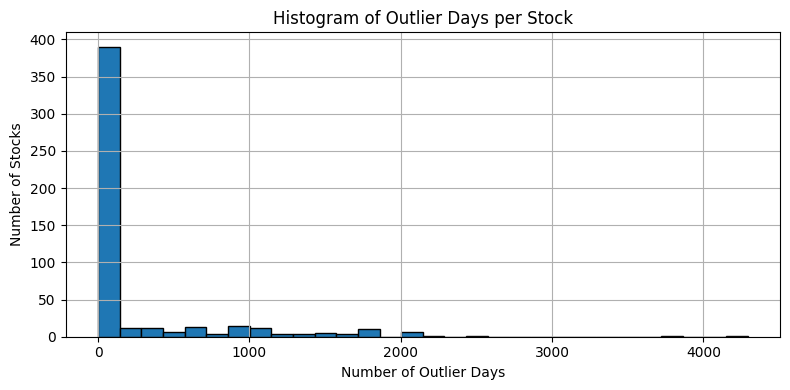

In [2381]:
stale_df = stale_df_raw.copy()

from scipy.stats import zscore
z_scores = stale_df.apply(zscore, axis=1, nan_policy='omit')
threshold = 2
outlier_df = (np.abs(z_scores) > threshold).astype(int)


outlier_counts = outlier_df.sum()
plt.figure(figsize=(8, 4))
plt.hist(outlier_counts, bins=30, edgecolor='black')
plt.title("Histogram of Outlier Days per Stock")
plt.xlabel("Number of Outlier Days")
plt.ylabel("Number of Stocks")
plt.grid(True)
plt.tight_layout()
plt.show()

In [2382]:
stale_df = stale_df.loc[:,~(outlier_df.sum()>0)]
len(stale_df.columns)

371

In [2383]:
returns_dict = {}
for ticker in tickers:
    series = data_full[ticker].ffill()
    returns_dict[ticker] = series.pct_change(periods=180,fill_method=None).mul(100).round(2)
returns_df = pd.DataFrame(returns_dict)
len(returns_df.columns)

500

In [2384]:
from scipy.stats import zscore
z_scores = returns_df.apply(zscore, axis=1, nan_policy='omit')
threshold = 2
outlier_df = (np.abs(z_scores) > threshold).astype(int)

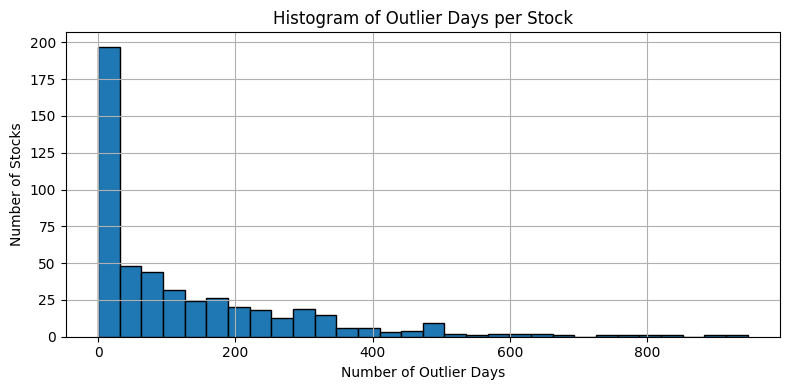

In [2385]:
outlier_counts = outlier_df.sum()
plt.figure(figsize=(8, 4))
plt.hist(outlier_counts, bins=30, edgecolor='black')
plt.title("Histogram of Outlier Days per Stock")
plt.xlabel("Number of Outlier Days")
plt.ylabel("Number of Stocks")
plt.grid(True)
plt.tight_layout()
plt.show()

In [2398]:
# returns_df = returns_df.loc[:,~(outlier_df.sum()>0)]
returns_df = returns_df.loc[:,returns_df.min() > -60]
len(returns_df.columns)

228

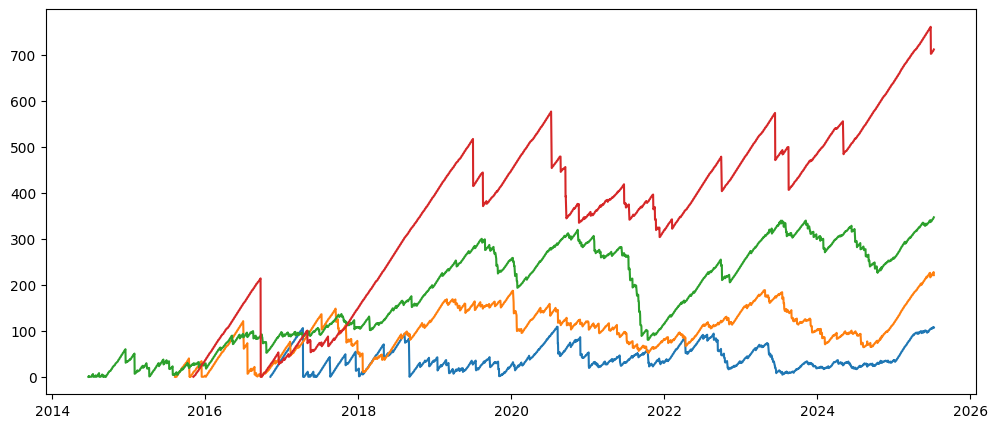

In [2378]:
df = stale_df.copy()
plt.figure(figsize=(12, 5))
for i in range(0,500,50):
    temp = df[df.mean().sort_values().iloc[i:i+50].index.to_list()].mean(axis=1)
    plt.plot(temp, label='i')
    # print(temp)

In [ ]:
# returns_df = returns_df.loc[:,returns_df.min() > -60]

In [2400]:
# Parameters
alpha = 0.5  # Weight: 0.5 = equal weight to stability and growth
top_n = 400

# Step 1: Align tickers
common_tickers = stale_df.columns.intersection(returns_df.columns)
stale_df = stale_df[common_tickers]
returns_df = returns_df[common_tickers]

# Step 2: Normalize scores
stale_score = 1 - stale_df.mean().rank(pct=True)        # Lower stale = better
returns_score = returns_df.iloc[-1].rank(pct=True)      # Higher return = better

# Step 3: Combine
combined_score = alpha * returns_score + (1 - alpha) * stale_score
combined_score = combined_score.dropna().sort_values(ascending=False)

# Step 4: Select Top Stocks
top_stocks = combined_score.head(top_n)
top_stocks_df = pd.DataFrame({
    'Stale_Score': stale_score[top_stocks.index],
    'Returns_Score': returns_score[top_stocks.index],
    'Combined_Score': top_stocks
})

# Output
top_stocks_df

,Stale_Score,Returns_Score,Combined_Score
AIIL.NS,0.995098,0.955882,0.975490
LLOYDSME.NS,0.931373,0.970588,0.950980
MAZDOCK.NS,0.906863,0.946078,0.926471
MAXHEALTH.NS,0.950980,0.901961,0.926471
KIMS.NS,0.897059,0.921569,0.909314
...,...,...,...
SONACOMS.NS,0.107843,0.063725,0.085784
JSWENERGY.NS,0.053922,0.107843,0.080882
ROUTE.NS,0.127451,0.024510,0.075980
GPPL.NS,0.004902,0.147059,0.075980


In [2401]:
data_top = top_stocks_df[(top_stocks_df['Stale_Score']>0.5) & (top_stocks_df['Returns_Score']>0.5)]

In [3346]:
len(data_top.index)

53

In [ ]:
data_top = data[data_top.index.to_list()].loc[:, ~data[data_top.index.to_list()].iloc[-1500].isna()]

In [ ]:
data_top

In [ ]:
list1 = ['A', 'B', 'C', 'D']
list2 = ['C', 'D', 'E', 'F']
# Convert to sets
s1, s2 = set(list1), set(list2)
# print("Intersection:", s1 & s2)
# print("Union:", s1 | s2)
# print("Only in list1:", s1 - s2)
# print("Not common", s1 ^ s2)

In [ ]:
my_stocks = ['HAL.NS', 'KEI.NS', 'TRENT.NS', 'KIRLOSBROS.NS', 'KPITTECH.NS', 'VBL.NS', 'SOLARINDS.NS', 'JINDALSTEL.NS','SIEMENS.NS','ADANIENT.NS']

In [ ]:
my_stocks_right = list(set(my_stocks)&set(combined_score.index.tolist()))
my_stocks_right

In [ ]:
my_stocks_wrong = list(set(my_stocks)-set(combined_score.index.tolist()))
my_stocks_wrong

In [ ]:
df = data[list(set(my_stocks)-set(combined_score.index.tolist()))].loc['2020-03-23':]

# Calculate daily % change and then cumulative sum
df_returns = df.pct_change(fill_method=None).replace([np.inf, -np.inf], np.nan).fillna(0)
df_cum_returns = df_returns.cumsum()

last_row = df_cum_returns.iloc[-1]
top_5_cols = last_row.nlargest(20).index
df_cum_returns = df_cum_returns[top_5_cols]

# Plot
plt.figure(figsize=(18, 10))
for col in df_cum_returns.columns:
    plt.plot(df_cum_returns.index, df_cum_returns[col], label=col)

plt.title('Cumulative Returns of FMCG Stocks', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Cumulative Return (Sum of Daily % Change)', fontsize=14)
plt.legend(loc='lower right', fontsize=9, ncol=2)
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
df = data[list(set(my_stocks)&set(combined_score.index.tolist()))].loc['2020-03-23':]

# Calculate daily % change and then cumulative sum
df_returns = df.pct_change(fill_method=None).replace([np.inf, -np.inf], np.nan).fillna(0)
df_cum_returns = df_returns.cumsum()

last_row = df_cum_returns.iloc[-1]
top_5_cols = last_row.nlargest(20).index
df_cum_returns = df_cum_returns[top_5_cols]

# Plot
plt.figure(figsize=(18, 10))
for col in df_cum_returns.columns:
    plt.plot(df_cum_returns.index, df_cum_returns[col], label=col)

plt.title('Cumulative Returns of FMCG Stocks', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Cumulative Return (Sum of Daily % Change)', fontsize=14)
plt.legend(loc='lower right', fontsize=9, ncol=2)
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
df = data_top.loc['2022-06-23':]

# Calculate daily % change and then cumulative sum
df_returns = df.pct_change(fill_method=None).replace([np.inf, -np.inf], np.nan).fillna(0)
df_cum_returns = df_returns.cumsum()

last_row = df_cum_returns.iloc[-1]
top_5_cols = last_row.nlargest(20).index
df_cum_returns = df_cum_returns[top_5_cols]

# Plot
plt.figure(figsize=(18, 10))
for col in df_cum_returns.columns:
    plt.plot(df_cum_returns.index, df_cum_returns[col], label=col)

plt.title('Cumulative Returns of FMCG Stocks', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Cumulative Return (Sum of Daily % Change)', fontsize=14)
plt.legend(loc='lower right', fontsize=9, ncol=2)
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
df = data_top.loc['2022-06-23':]
df_returns = df.pct_change(fill_method=None).replace([np.inf, -np.inf], np.nan).fillna(0)
df_cum_returns_top_stocks_df = df_returns.cumsum().mean(axis=1)

df = data[my_stocks_right].loc['2022-06-23':]
df_returns = df.pct_change(fill_method=None).replace([np.inf, -np.inf], np.nan).fillna(0)
df_cum_returns_my_stocks_right = df_returns.cumsum().mean(axis=1)

df = data[my_stocks_wrong].loc['2022-06-23':]
df_returns = df.pct_change(fill_method=None).replace([np.inf, -np.inf], np.nan).fillna(0)
df_cum_returns_my_stocks_wrong = df_returns.cumsum().mean(axis=1)

df = data[NIFTY_500.columns.tolist()].loc['2022-06-23':]
df_returns = df.pct_change(fill_method=None).replace([np.inf, -np.inf], np.nan).fillna(0)
df_cum_returns_nifty_500 = df_returns.cumsum().mean(axis=1)

plt.figure(figsize=(12,6))
plt.plot(df_cum_returns_top_stocks_df,label='top')
plt.plot(df_cum_returns_my_stocks_right,label='right')
plt.plot(df_cum_returns_my_stocks_wrong, label='wrong')
plt.plot(df_cum_returns_nifty_500, label='nifty_500')

plt.legend(title="Index", fontsize=12)

In [ ]:
df = data_top.loc['2020-03-23':]
df_returns = df.pct_change(fill_method=None).replace([np.inf, -np.inf], np.nan).fillna(0)
df_cum_returns_top_stocks_df = df_returns.cumsum().mean(axis=1)

df = data[my_stocks_right].loc['2020-03-23':]
df_returns = df.pct_change(fill_method=None).replace([np.inf, -np.inf], np.nan).fillna(0)
df_cum_returns_my_stocks_right = df_returns.cumsum().mean(axis=1)

df = data[my_stocks_wrong].loc['2020-03-23':]
df_returns = df.pct_change(fill_method=None).replace([np.inf, -np.inf], np.nan).fillna(0)
df_cum_returns_my_stocks_wrong = df_returns.cumsum().mean(axis=1)

df = data[NIFTY_500.columns.tolist()].loc['2020-03-23':]
df_returns = df.pct_change(fill_method=None).replace([np.inf, -np.inf], np.nan).fillna(0)
df_cum_returns_nifty_500 = df_returns.cumsum().mean(axis=1)

plt.figure(figsize=(12,6))
plt.plot(df_cum_returns_top_stocks_df,label='top')
plt.plot(df_cum_returns_my_stocks_right,label='right')
plt.plot(df_cum_returns_my_stocks_wrong, label='wrong')
plt.plot(df_cum_returns_nifty_500, label='nifty_500')

plt.legend(title="Index", fontsize=12)

In [ ]:
df = data[my_stocks_right].loc['2022-06-23':]

# Calculate daily % change and then cumulative sum
df_returns = df.pct_change(fill_method=None).replace([np.inf, -np.inf], np.nan).fillna(0)
df_cum_returns = df_returns.cumsum()

last_row = df_cum_returns.iloc[-1]
top_5_cols = last_row.nlargest(20).index
df_cum_returns = df_cum_returns[top_5_cols]

# Plot
plt.figure(figsize=(18, 10))
for col in df_cum_returns.columns:
    plt.plot(df_cum_returns.index, df_cum_returns[col], label=col)

plt.title('Cumulative Returns of FMCG Stocks', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Cumulative Return (Sum of Daily % Change)', fontsize=14)
plt.legend(loc='lower right', fontsize=9, ncol=2)
plt.grid(True)
plt.tight_layout()
plt.show()

### Top Retun Giver

In [ ]:
tickers =  NIFTY_500.columns.tolist()
data_full_w = yf.download(['^CRSLDX']+tickers, start="2001-01-02", interval="1wk", auto_adjust=True)['Close']

In [ ]:
data_full_w = data_full_w.resample('W').last()

In [ ]:
index_data = data_full_w[NIFTY_500.columns.tolist()]
stock_data = data_full_w.drop(columns='^CRSLDX')

In [ ]:
# data_full_w = data_full[NIFTY_100.columns.tolist()].resample('W').last()

data_full_w = data_full_w.loc[:'2024-02-09', ~data_full_w.iloc[-300].isna()]

# 1. Calculate 52-week percentage change (i.e., rolling 1-year return)
pct_52w = data_full_w.pct_change(periods=50,fill_method=None)

# 2. Rank tickers weekly based on 52-week return (higher return = better rank = 1)
rank_52w = pct_52w.rank(axis=1, ascending=False, method='min')  # method='min' gives lowest rank to ties

# rank_52w = rank_52w.loc[:, ~((rank_52w > 60).any())]
top_10_ranks = rank_52w.map(lambda x: x if x <= 100 else np.nan)
data_top = top_10_ranks.mean().dropna().sort_values().head(1)
data_top

In [ ]:
date = '2020-06-23'
data = data_full
df = data[data_top.index.tolist()].loc[date:]
df_returns = df.pct_change(fill_method=None).replace([np.inf, -np.inf], np.nan).fillna(0)
df_cum_returns_top_stocks_df = df_returns.cumsum().mean(axis=1)

# df = data[my_stocks_right].loc[date:]
# df_returns = df.pct_change(fill_method=None).replace([np.inf, -np.inf], np.nan).fillna(0)
# df_cum_returns_my_stocks_right = df_returns.cumsum().mean(axis=1)

# df = data[my_stocks_wrong].loc[date:]
# df_returns = df.pct_change(fill_method=None).replace([np.inf, -np.inf], np.nan).fillna(0)
# df_cum_returns_my_stocks_wrong = df_returns.cumsum().mean(axis=1)

df = data[NIFTY_500.columns.tolist()].loc[date:]
df_returns = df.pct_change(fill_method=None).replace([np.inf, -np.inf], np.nan).fillna(0)
df_cum_returns_nifty_500 = df_returns.cumsum().mean(axis=1)

plt.figure(figsize=(12,6))
plt.plot(df_cum_returns_top_stocks_df,label='top')
# plt.plot(df_cum_returns_my_stocks_right,label='right')
# plt.plot(df_cum_returns_my_stocks_wrong, label='wrong')
plt.plot(df_cum_returns_nifty_500, label='nifty_500')

plt.legend(title="Index", fontsize=12)

In [ ]:
df = data[data_top.index.tolist()].loc[date:]

# Calculate daily % change and then cumulative sum
df_returns = df.pct_change(fill_method=None).replace([np.inf, -np.inf], np.nan).fillna(0)
df_cum_returns = df_returns.cumsum()

last_row = df_cum_returns.iloc[-1]
top_5_cols = last_row.nlargest(20).index
df_cum_returns = df_cum_returns[top_5_cols]

# Plot
plt.figure(figsize=(18, 10))
for col in df_cum_returns.columns:
    plt.plot(df_cum_returns.index, df_cum_returns[col], label=col)

plt.title('Cumulative Returns of FMCG Stocks', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Cumulative Return (Sum of Daily % Change)', fontsize=14)
plt.legend(loc='lower right', fontsize=9, ncol=2)
plt.grid(True)
plt.tight_layout()
plt.show()

### top 4 every month

In [5]:
nifty500_w = yf.download('^CNX500', start="2021-01-01", interval="1wk", auto_adjust=True)['Close']

[*********************100%***********************]  1 of 1 completed

1 Failed download:
['^CNX500']: HTTPError('HTTP Error 404: ')


In [ ]:
# nifty100_w = yf.download('^CNX100', start="2001-01-01", interval="1wk", auto_adjust=True)['Close']

In [3611]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# SETUP
# -----------------------------
tickers = [...]  # List of Nifty 500 tickers
nifty500_ticker = "^CRSLDX"  # Or another Nifty 500 proxy
start_date = "2005-01-01"
monthly_investment = 5000
monthly_index_investment = 5000
top_n = 10

# -----------------------------
# DOWNLOAD DATA
# -----------------------------
# data = yf.download(tickers + [nifty500_ticker], start=start_date, interval="1mo", auto_adjust=True)['Close']

# Drop months with too many missing values

# data = data_full_w.dropna(thresh=len(data.columns) * 0.8)

# # Separate index
index_data = nifty100_w.copy()
# stock_data = data_full_w[NIFTY_100.columns.values.tolist()].copy()
stock_data = data_full_w.copy()


# stock_data = stock_data[top_stocks_df.index.values.tolist()].loc['2005-11-27':'2025-07-06',:].iloc[17:,:]  # 17, 153,300,387,515, 731,846
stock_data = stock_data.loc['2005-11-27':'2025-07-06',:].iloc[387:,:]  # 17, 153,300,387,515, 731, 846
# nifty100_w.index = nifty100_w.index + pd.Timedelta(days=2)
index_data = index_data.loc['2005-11-27':'2025-07-06',:].iloc[387:,:] # 2006/7, 2009/3,2012/1,2013/9,2016/3, 2020/3,2022/6

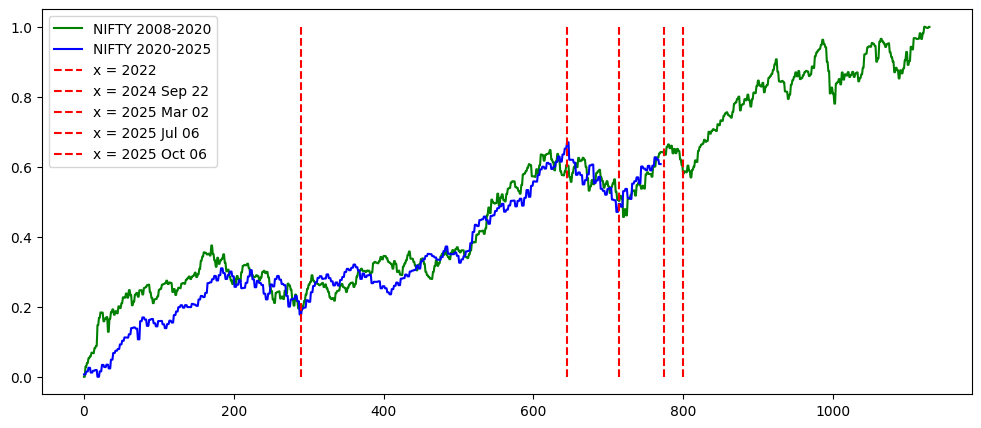

In [3364]:
list2009 = index_data.loc['2005-11-27':'2025-07-06',:].iloc[155:720,:].reindex().iloc[:,-1].values[:800]
list2009 = [x for x in list2009 for _ in (0, 1)]
list2009 = (list2009-min(list2009))/(max(list2009)-min(list2009))

list2020 = index_data.loc['2005-11-27':'2025-07-06',:].iloc[750:,:].reindex().iloc[:,-1].values[:800]
list2020 = [x for x in list2020 for _ in (0, 1, 2)]
list2020 = (list2020-min(list2020))/(max(list2020)-min(list2020))
list2020 = [x * 0.67 for x in list2020]


plt.figure(figsize=(12,5))
plt.plot(list2009,label='NIFTY 2008-2020', color='green')

plt.plot(list2020, label='NIFTY 2020-2025', color='blue')

plt.plot([290, 290], [0, 1], 'r--', label='x = 2022')
plt.plot([645, 645], [0, 1], 'r--', label='x = 2024 Sep 22')
plt.plot([714, 714], [0, 1], 'r--', label='x = 2025 Mar 02')
plt.plot([774, 774], [0, 1], 'r--', label='x = 2025 Jul 06')
plt.plot([800, 800], [0, 1], 'r--', label='x = 2025 Oct 06')
plt.legend()


In [3317]:
# week left from today 06 Jul 2025 to next nifty fall day (est - 15 Oct 2025)
int((810-770)/3)

13

In [3321]:
index_data.loc['2005-11-27':'2025-07-06',:].iloc[750:,:].reindex().iloc[int(770/3),]

Ticker
^CNX100    25760.800781
Name: 2025-07-06 00:00:00, dtype: float64

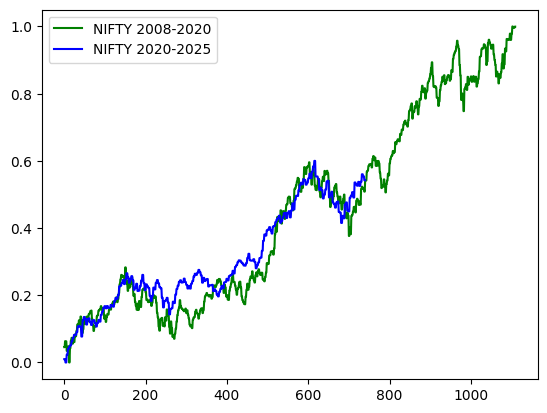

In [3243]:
list2009 = index_data.loc['2005-11-27':'2025-07-06',:].iloc[165:720,:].reindex().iloc[:,-1].values[:800]
list2009 = [x for x in list2009 for _ in (0, 1)]
list2009 = (list2009-min(list2009))/(max(list2009)-min(list2009))

list2020 = index_data.loc['2005-11-27':'2025-07-06',:].iloc[760:,:].reindex().iloc[:,-1].values[:800]
list2020 = [x for x in list2020 for _ in (0, 1, 2)]
list2020 = (list2020-min(list2020))/(max(list2020)-min(list2020))
list2020 = [x * 0.6 for x in list2020]

plt.plot(list2009,label='NIFTY 2008-2020', color='green')

plt.plot(list2020, label='NIFTY 2020-2025', color='blue')
plt.legend()

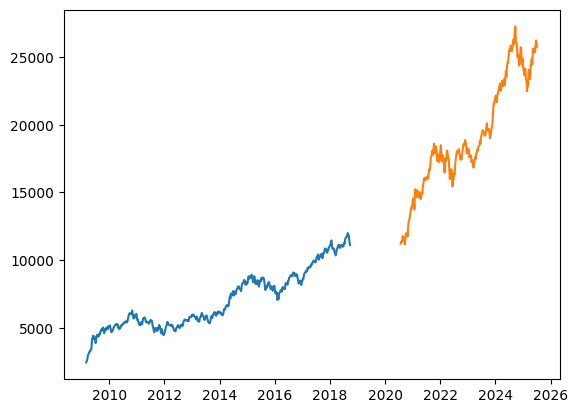

In [3070]:
plt.plot(index_data.loc['2005-11-27':'2025-07-06',:].iloc[153:,:].reindex().head(500))
plt.plot(index_data.loc['2005-11-27':'2025-07-06',:].iloc[748:,:].reindex().head(500))

In [3446]:
# prev_date_ = stock_data.index[max(0,i-4)]                # Gap
prev_date = index_data.loc[index_data.iloc[max(0,i-1):i].idxmin()].index.tolist()[0]
prev_date

Timestamp('2025-06-22 00:00:00')

In [3556]:
monthly_momentum_investment

34051

In [3617]:
top_stocks

Index(['NETWEB.NS', 'COCHINSHIP.NS', 'ANGELONE.NS', 'FIRSTCRY.NS',
       'UNITDSPR.NS', 'SCHNEIDER.NS', 'KALYANKJIL.NS', 'BSE.NS', 'IRCON.NS',
       'IEX.NS', 'HUDCO.NS', 'MAPMYINDIA.NS', 'NAM-INDIA.NS', 'CAMS.NS',
       'CDSL.NS', 'PVRINOX.NS', 'JYOTICNC.NS', 'MAZDOCK.NS', 'CONCOR.NS',
       'GRSE.NS', 'STARHEALTH.NS', 'IRFC.NS', 'CAMPUS.NS', 'CRAFTSMAN.NS',
       'SWANENERGY.NS', 'SJVN.NS', 'ATUL.NS', 'SUMICHEM.NS', 'KAYNES.NS',
       'IREDA.NS', 'TIINDIA.NS', 'RAILTEL.NS', 'LODHA.NS', 'GLAXO.NS',
       'MANYAVAR.NS', 'HONASA.NS', 'INDIGO.NS', 'PREMIERENE.NS',
       'APLAPOLLO.NS', 'LTFOODS.NS', 'SHYAMMETL.NS', 'AAVAS.NS', 'RRKABEL.NS',
       'DIXON.NS', 'NHPC.NS', 'DMART.NS', 'SBFC.NS', 'DOMS.NS', 'POWERGRID.NS',
       'RITES.NS', 'PRESTIGE.NS', 'SAPPHIRE.NS', 'ENDURANCE.NS', 'KFINTECH.NS',
       'BAJAJHFL.NS', 'BLUEDART.NS', 'DEVYANI.NS', 'SHRIRAMFIN.NS', 'DABUR.NS',
       'RECLTD.NS', 'PPLPHARMA.NS', 'NIACL.NS', 'ICICIGI.NS', 'TBOTEK.NS',
       'PFC.NS', 'NUVAMA.NS', 

2.66


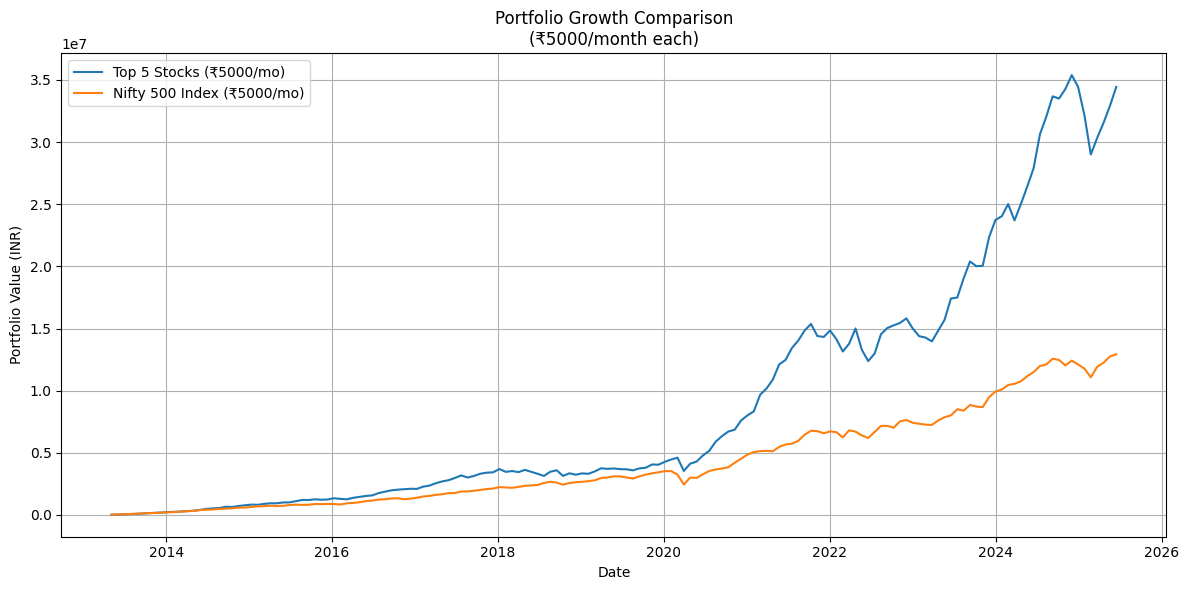

In [3619]:
# Market badh raha ho (index_pct_diff) tab extra amount invest karna chahiye. (proved)
# Koi stock ne jayda diff de diya ho to usme kam invest karna chahiya. (proved)
# Weekly Top1 me lagane se better hai Month me top 4 par lagana. Weekly top volatile hota hai, Monthly top momentum hota hai (proved)
# Jo stock performed kar chuke 2020 tak, jinhe 2016 me lena tha, unmhe 2020 me buy mat karna, they are already ripe (no more on discount). Never buy past recommended stock on present day. (proved)
# Past analysis outliers ko find karne ke liye karna hota hai, ki kin stocks ko aaj kisi bhi condition me nahi buy karna, they are not real fruit. Exclude the past outliers from data. (proved)
# 


# import yfinance as yf
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt

# -----------------------------
# SETUP
# -----------------------------
tickers = [...]  # <- Replace with your list of Nifty 500 stock tickers
# nifty500_ticker = "^CRSLDX"  # or another Nifty 500 proxy like "^NSE500"
# start_date = "2005-01-01"
monthly_momentum_investment = 5000
monthly_index_investment = 5000
top_n = 1

# -----------------------------
# DOWNLOAD DATA
# -----------------------------
# data = yf.download(tickers + [nifty500_ticker], start=start_date, interval="1mo", auto_adjust=True)['Close']
# data = data.dropna(thresh=len(data.columns) * 0.8)

# # Split index and stocks
# index_data = data[nifty500_ticker].reindex(data.index).ffill()
# stock_data = data.drop(columns=nifty500_ticker)

# -----------------------------
# SIMULATION (No selling)
# -----------------------------

portfolio_units = {}  # Momentum: Ticker → cumulative units
portfolio_costs = {}  # ticker → total ₹ invested
index_units = 0
dates = []
momentum_values = []
index_values = []

investment = 5000*4


for i in range(1, len(stock_data),4):               # Monthly investment is best

    date = stock_data.index[i]
    # prev_date = stock_data.index[max(0,i-4)]                # Gap
    prev_date = index_data.loc[index_data.iloc[max(0,i-4):i].idxmin()].index.tolist()[0]


    # Calculate previous month's returns
    prev_prices = stock_data.loc[prev_date]
    curr_prices = stock_data.loc[date]
    monthly_return = (curr_prices / prev_prices) - 1
    # Select top N stocks
    monthly_return = monthly_return.loc[top_stocks_df.index.values.tolist()]        # Very important to exclude outliers
    top_stocks = monthly_return.sort_values(ascending=False)[:(top_n)].index
    
    investment = int(investment*(1.0081))
    # investment = int(investment*(1.0021))
    # index_pct_diff = (((index_data.loc[index_data.index[i]]/index_data.loc[index_data.index[0]])-4).values[-1]*(10)*investment)
    # monthly_momentum_investment = (investment+index_pct_diff) # Market badh raha ho tab extra amount invest karna chahiye.(proved). Koi stock ne jayda diff de diya ho to usme kam invest karna chahiya.
    # monthly_index_investment = (investment+index_pct_diff)
    # monthly_momentum_investment = max(monthly_momentum_investment,0)
    # monthly_index_investment = max(monthly_momentum_investment,0)
    monthly_momentum_investment = investment
    monthly_index_investment = investment
    # print(i, monthly_momentum_investment-index_pct_diff)

    # Buy ₹1000 of each top stock
    for stock in top_stocks:
        price = stock_data.loc[date, stock]
        if pd.notna(price):
            amount = (monthly_momentum_investment / top_n)
            qty = amount / price
            portfolio_units[stock] = portfolio_units.get(stock, 0) + qty
            portfolio_costs[stock] = portfolio_costs.get(stock, 0) + amount

    # Buy ₹5000 of index
    index_price = index_data.loc[date].values[-1]
    if pd.notna(index_price):
        index_units += monthly_index_investment / index_price

    # Calculate current values
    portfolio_value = sum(
        portfolio_units[stk] * stock_data.loc[date, stk]
        for stk in portfolio_units
        if pd.notna(stock_data.loc[date, stk])
    )
    index_value = index_units * index_price

    dates.append(date)
    momentum_values.append(portfolio_value)
    index_values.append(index_value)

print((momentum_values[-1]/index_values[-1]).round(2))

plt.figure(figsize=(12, 6))
plt.plot(dates, momentum_values, label="Top 5 Stocks (₹5000/mo)")
plt.plot(dates, index_values, label="Nifty 500 Index (₹5000/mo)")
plt.title("Portfolio Growth Comparison\n(₹5000/month each)")
plt.xlabel("Date")
plt.ylabel("Portfolio Value (INR)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [3424]:
prev_date

Timestamp('2025-02-23 00:00:00')

In [3473]:
latest_date = stock_data.index[-1]

records = []
for stock, qty in portfolio_units.items():
    price = stock_data.loc[latest_date, stock]
    if pd.notna(price):
p=1
for stock in top_stocks:
    
    price = stock_data.loc[date, stock]
    if pd.notna(price):
        amount = int(monthly_momentum_investment / 1.93**p)
        p+=1
        qty = amount / price
        portfolio_units[stock] = portfolio_units.get(stock, 0) + qty
        portfolio_costs[stock] = portfolio_costs.get(stock, 0) + amount
        print(amount)        current_value = qty * price
        total_cost = portfolio_costs.get(stock, 0)
        total_return = (current_value - total_cost) / total_cost if total_cost > 0 else 0

        records.append({
            'ticker': stock,
            'quantity': qty,
            'value': current_value,
            'cost': total_cost,
            'return_pct': total_return * 100  # in %
        })

holdings_df = pd.DataFrame(records).set_index('ticker')
holdings_df = holdings_df.sort_values(by='value', ascending=False).astype(int)
print(len(holdings_df))
# holdings_df

167


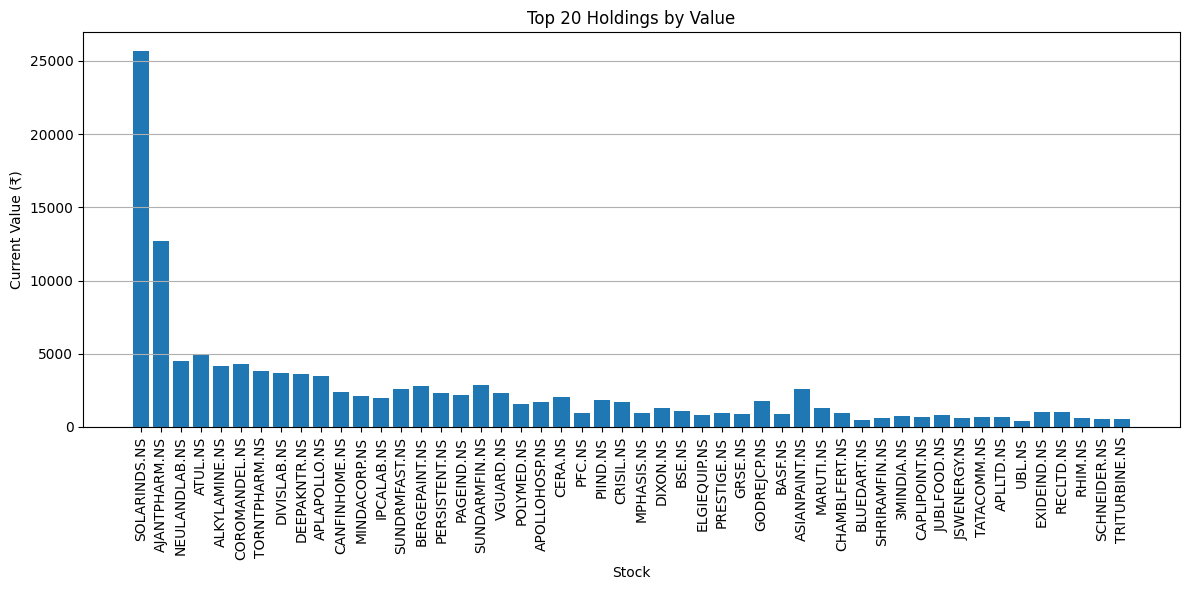

In [3474]:
#weekly
top_holdings = holdings_df.sort_values(by='value', ascending=False).head(50)

plt.figure(figsize=(12, 6))
plt.bar(x=top_holdings.index, height=top_holdings['return_pct'])
plt.xlabel("Stock")
plt.ylabel("Current Value (₹)")
plt.title("Top 20 Holdings by Value")
plt.xticks(rotation=90)
plt.tight_layout()
plt.grid(axis='y')
plt.show()

In [2904]:
# Monthly
top_holdings.sum()

quantity         2014
value         1950845
cost           686543
return_pct       9808
dtype: int64

In [2905]:
top_holdings.sum().values[-3]/top_holdings.sum().values[-2]

2.8415481623146692

In [2709]:
set(my_stocks_after_2020)-set(my_stocks_after_2020)

set()

In [2728]:
my_stocks_after_2020

['NEULANDLAB.NS',
 'BSE.NS',
 'GRSE.NS',
 'MAZDOCK.NS',
 'SCHNEIDER.NS',
 'IRCON.NS',
 'KALYANKJIL.NS',
 'PERSISTENT.NS',
 'ANGELONE.NS',
 'AFFLE.NS']

In [2701]:
my_stocks_after_2020 = my_stocks.copy()

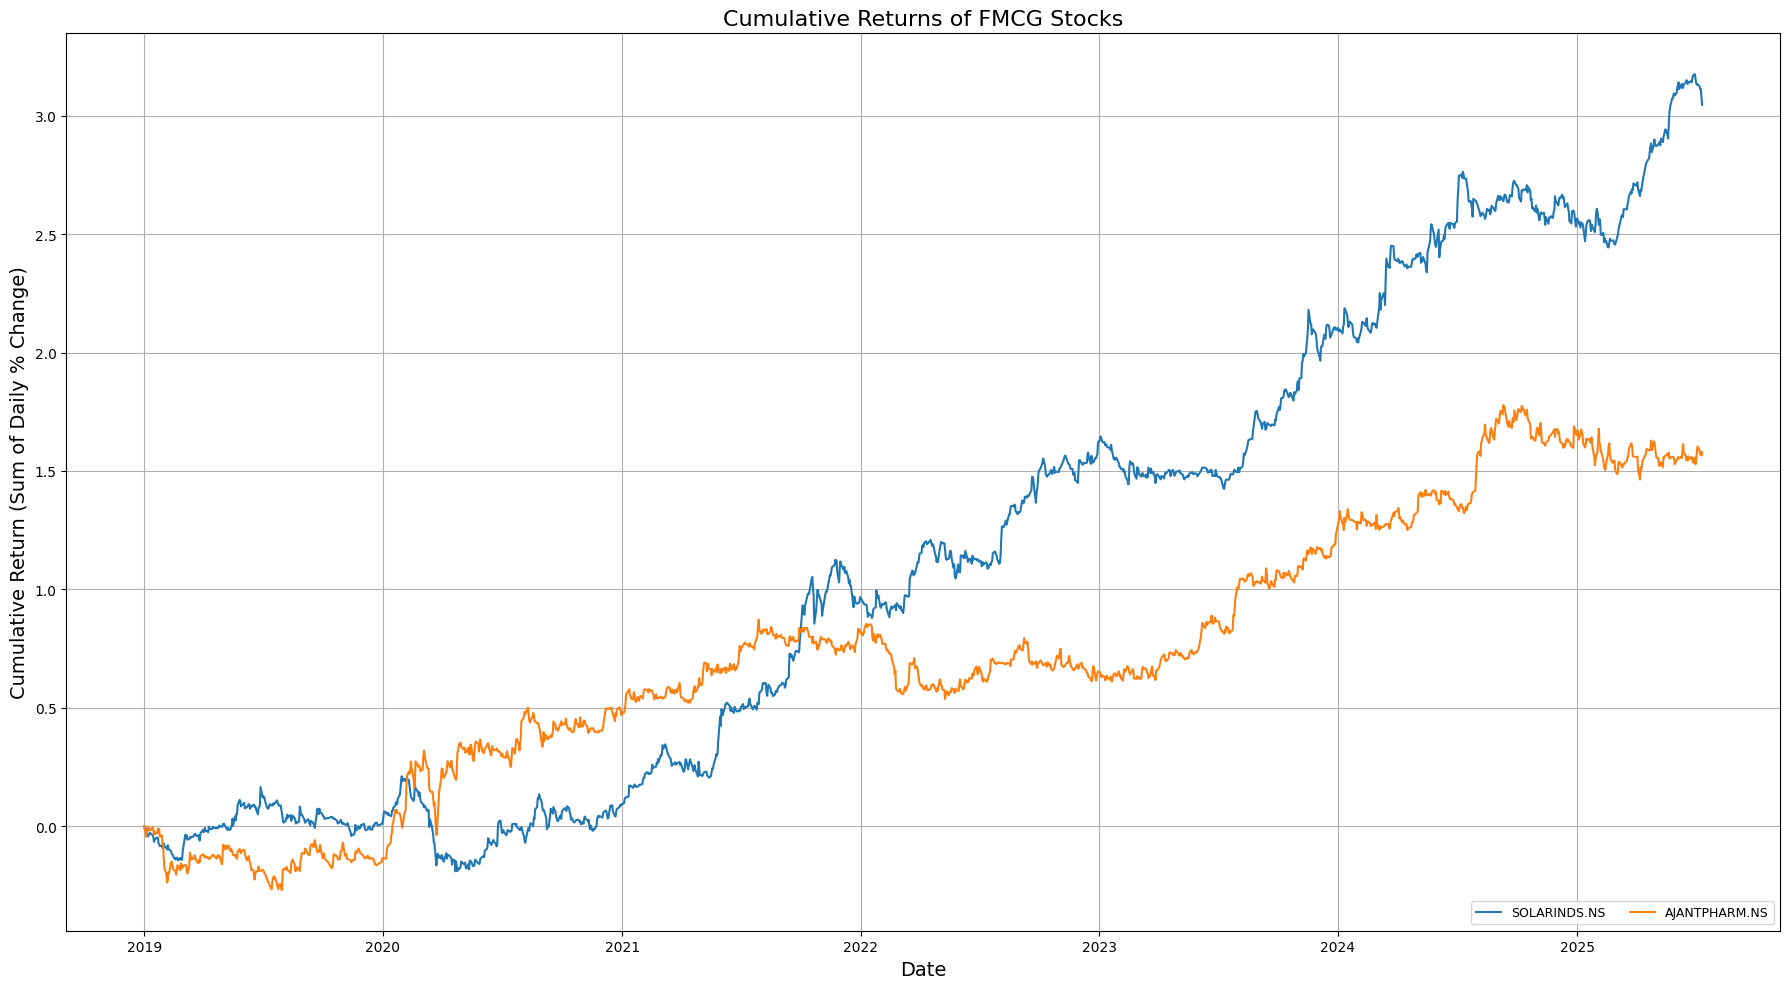

In [2841]:
my_stocks = ['HAL.NS','KEI.NS','TRENT.NS','KIRLOSBROS.NS','KPITTECH.NS','VBL.NS','SOLARINDS.NS','JINDALSTEL.NS','SIEMENS.NS']
my_stocks = holdings_df.sort_values(by='value', ascending=False).head(2).index.values.tolist()

df = NIFTY_500[my_stocks]
# .loc['2020-03-23':]

# Calculate daily % change and then cumulative sum
df_returns = df.pct_change(fill_method=None).replace([np.inf, -np.inf], np.nan).fillna(0)
df_cum_returns = df_returns.cumsum()

last_row = df_cum_returns.iloc[-1]
top_5_cols = last_row.nlargest(10).index
df_cum_returns = df_cum_returns[top_5_cols]

# Plot
plt.figure(figsize=(18, 10))
for col in df_cum_returns.columns:
    plt.plot(df_cum_returns.index, df_cum_returns[col], label=col)

plt.title('Cumulative Returns of FMCG Stocks', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Cumulative Return (Sum of Daily % Change)', fontsize=14)
plt.legend(loc='lower right', fontsize=9, ncol=2)
plt.grid(True)
plt.tight_layout()
plt.show()


In [3566]:
NIFTY_500

Ticker,360ONE.NS,3MINDIA.NS,ABB.NS,ACC.NS,ACMESOLAR.NS,AIAENG.NS,APLAPOLLO.NS,AUBANK.NS,AWL.NS,AADHARHFC.NS,...,WHIRLPOOL.NS,WIPRO.NS,WOCKPHARMA.NS,YESBANK.NS,ZFCVINDIA.NS,ZEEL.NS,ZENTEC.NS,ZENSARTECH.NS,ZYDUSLIFE.NS,ECLERX.NS
Date,,,,,,,,,,,,,,,,,,,,,
2019-01-01,NaN,19792.855469,1165.006348,1389.864502,NaN,1613.079834,114.826958,309.080902,NaN,NaN,...,1381.169189,118.030312,487.419281,181.756760,6817.949219,459.238861,78.160660,209.069458,332.159760,713.090149
2019-01-02,NaN,19141.021484,1165.050293,1385.336792,NaN,1592.029785,118.356552,308.236023,NaN,NaN,...,1373.548462,117.632851,477.279114,182.151352,6796.478027,449.676392,75.841507,207.945419,329.028381,724.630676
2019-01-03,NaN,19145.332031,1155.954346,1355.743530,NaN,1616.162476,115.708138,308.782715,NaN,NaN,...,1367.501099,117.614777,468.106873,181.608795,6734.643555,441.261444,74.607903,207.810547,326.086884,715.345154
2019-01-04,NaN,19496.962891,1151.273804,1371.473633,NaN,1588.079956,115.854996,310.025055,NaN,NaN,...,1367.550293,117.235382,470.780182,187.083694,6653.074707,443.652069,72.486130,206.146957,326.608734,712.592773
2019-01-07,NaN,19526.509766,1149.639893,1379.735596,NaN,1597.906494,112.785561,306.297882,NaN,NaN,...,1404.768921,117.163116,467.092865,184.617523,6421.009277,442.695801,72.239395,205.742325,331.068512,709.641357
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-07-07,1253.000000,29255.000000,5844.000000,1964.500000,254.610001,3353.000000,1734.099976,813.849976,257.200012,455.049988,...,1372.800049,267.750000,1703.500000,20.000000,13137.000000,144.929993,1938.300049,843.544128,998.799988,3413.699951
2025-07-08,1220.400024,29515.000000,5840.000000,1980.000000,258.329987,3444.800049,1741.400024,819.849976,263.250000,450.649994,...,1333.000000,269.649994,1657.800049,20.000000,13221.000000,145.839996,1953.599976,833.970154,983.200012,3368.800049
2025-07-09,1194.599976,29495.000000,5898.000000,1990.599976,262.950012,3459.100098,1708.300049,825.750000,262.750000,449.350006,...,1347.900024,267.799988,1717.000000,19.910000,13172.000000,141.789993,1953.800049,838.214233,978.450012,3372.000000


In [3582]:
df = NIFTY_500[top_stocks_df.index.tolist()].loc['2022-06-23':]
df = stock_data.drop(columns=['HINDZINC.NS','GVT&D.NS'])
# Calculate daily % change and then cumulative sum
df_returns = df.pct_change(fill_method=None).replace([np.inf, -np.inf], np.nan).fillna(0)
df_cum_returns = df_returns.cumsum()

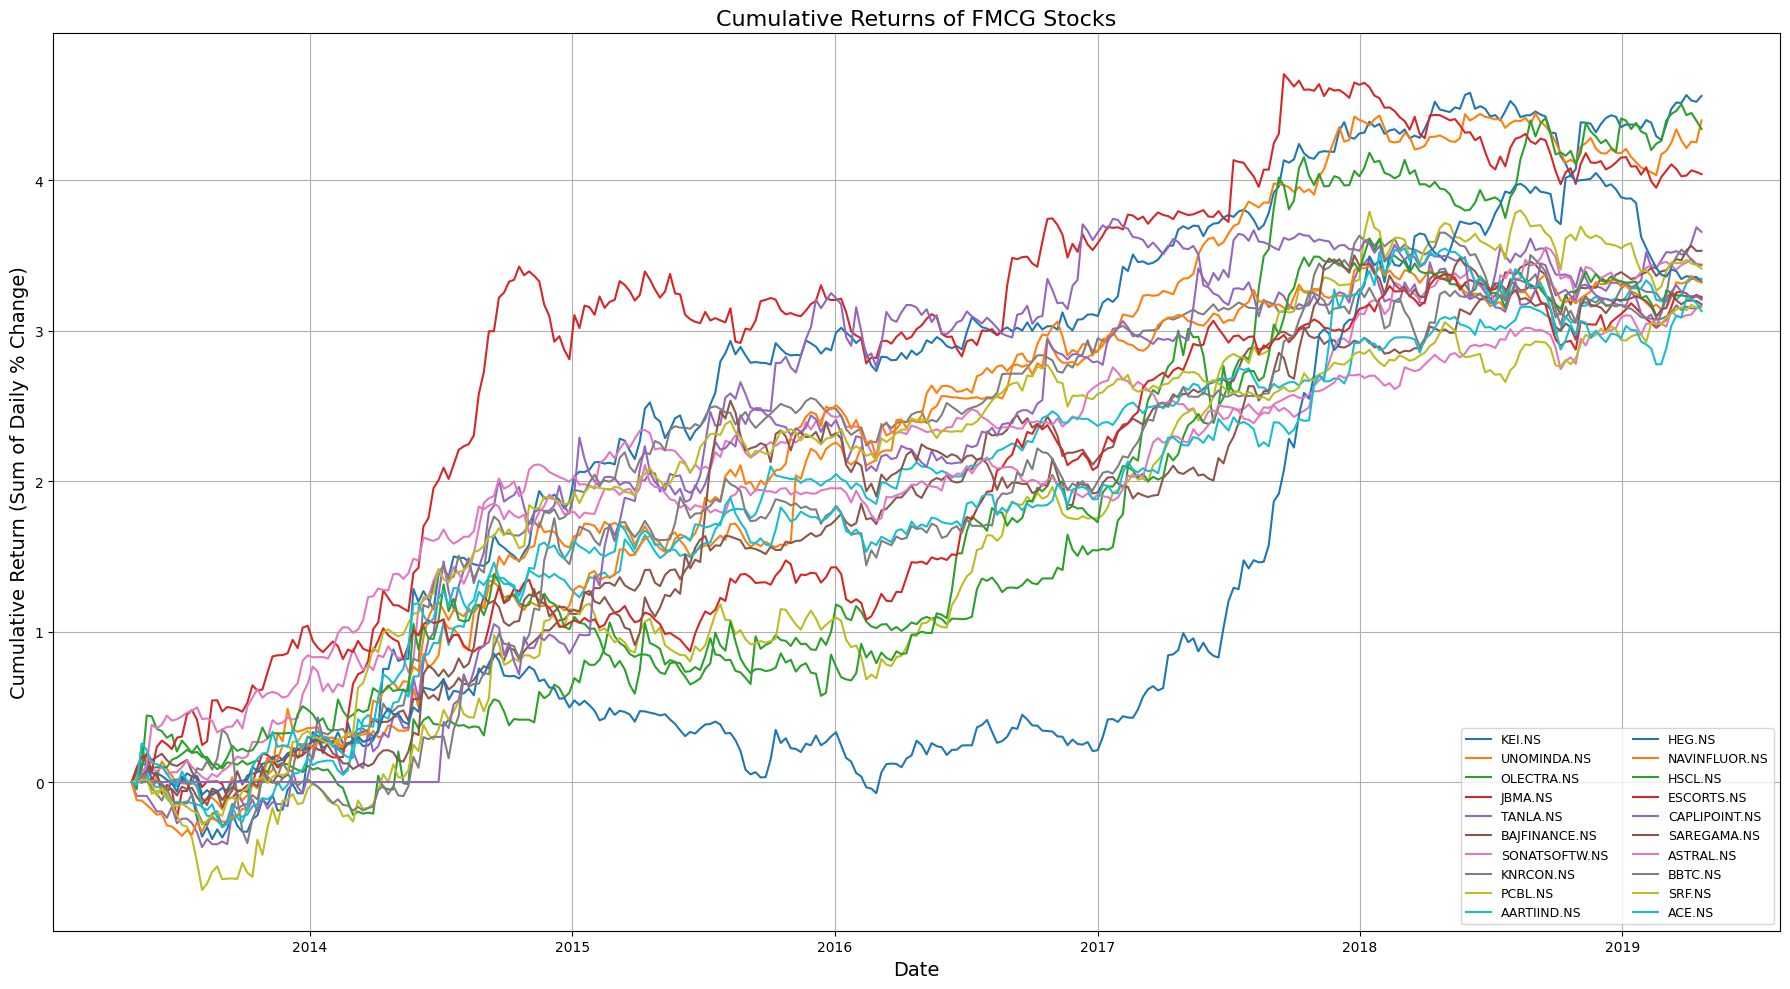

In [3583]:
last_row = df_cum_returns.iloc[-1]
top_5_cols = last_row.nlargest(20).index
df_cum_returns = df_cum_returns[top_5_cols]

# Plot
plt.figure(figsize=(18, 10))
for col in df_cum_returns.columns:
    plt.plot(df_cum_returns.index, df_cum_returns[col], label=col)

plt.title('Cumulative Returns of FMCG Stocks', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Cumulative Return (Sum of Daily % Change)', fontsize=14)
plt.legend(loc='lower right', fontsize=9, ncol=2)
plt.grid(True)
plt.tight_layout()
plt.show()

In [2746]:
my_stocks

['AJANTPHARM.NS',
 'ATUL.NS',
 'ALKYLAMINE.NS',
 'PAGEIND.NS',
 'SOLARINDS.NS',
 'CANFINHOME.NS',
 'BERGEPAINT.NS',
 'DEEPAKNTR.NS',
 'COROMANDEL.NS',
 'DIVISLAB.NS',
 'TORNTPHARM.NS',
 '3MINDIA.NS',
 'GODREJCP.NS',
 'IPCALAB.NS',
 'ASIANPAINT.NS',
 'PIIND.NS',
 'CERA.NS',
 'APOLLOHOSP.NS',
 'DABUR.NS',
 'MARUTI.NS',
 'CRISIL.NS',
 'SUNDRMFAST.NS',
 'VGUARD.NS',
 'EXIDEIND.NS',
 'APLAPOLLO.NS',
 'TCS.NS',
 'COLPAL.NS',
 'NEULANDLAB.NS',
 'JUBLFOOD.NS',
 'ELGIEQUIP.NS']

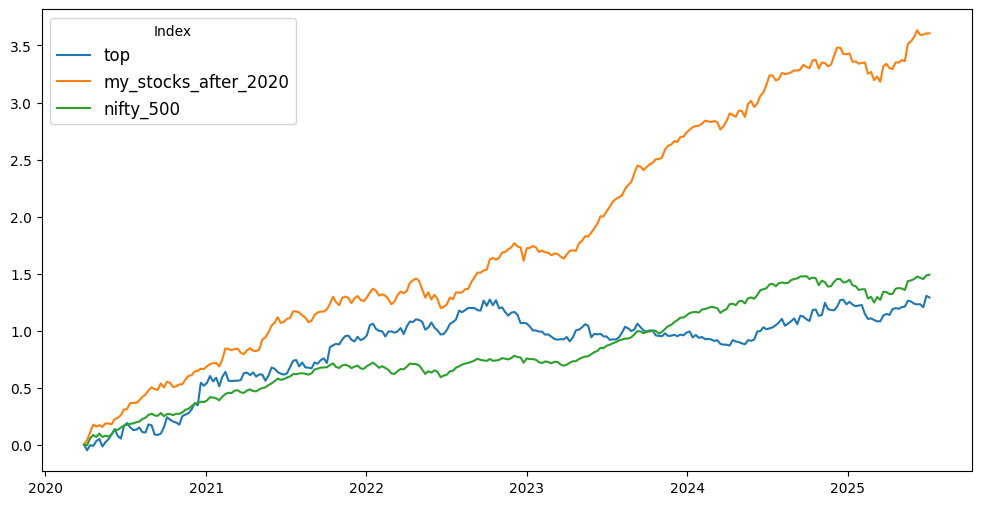

In [2756]:
df = stock_data.iloc[748:,:]
df_returns = df.pct_change(fill_method=None).replace([np.inf, -np.inf], np.nan).fillna(0)
df_cum_returns_nifty_500 = df_returns.cumsum().mean(axis=1)

df = stock_data[my_stocks_after_2020].iloc[748:,:]
df_returns = df.pct_change(fill_method=None).replace([np.inf, -np.inf], np.nan).fillna(0)
df_my_stocks_after_2020 = df_returns.cumsum().mean(axis=1)

df=stock_data[[my_stocks[3]]].iloc[748:,:]
df_returns = df.pct_change(fill_method=None).replace([np.inf, -np.inf], np.nan).fillna(0)
df_cum_returns_top_nifty_500_index = df_returns.cumsum().mean(axis=1)

plt.figure(figsize=(12,6))
plt.plot(df_cum_returns_top_nifty_500_index,label='top')
plt.plot(df_my_stocks_after_2020,label='my_stocks_after_2020')
# plt.plot(df_cum_returns_my_stocks_wrong, label='wrong')
plt.plot(df_cum_returns_nifty_500, label='nifty_500')

plt.legend(title="Index", fontsize=12)

### Chat GPT

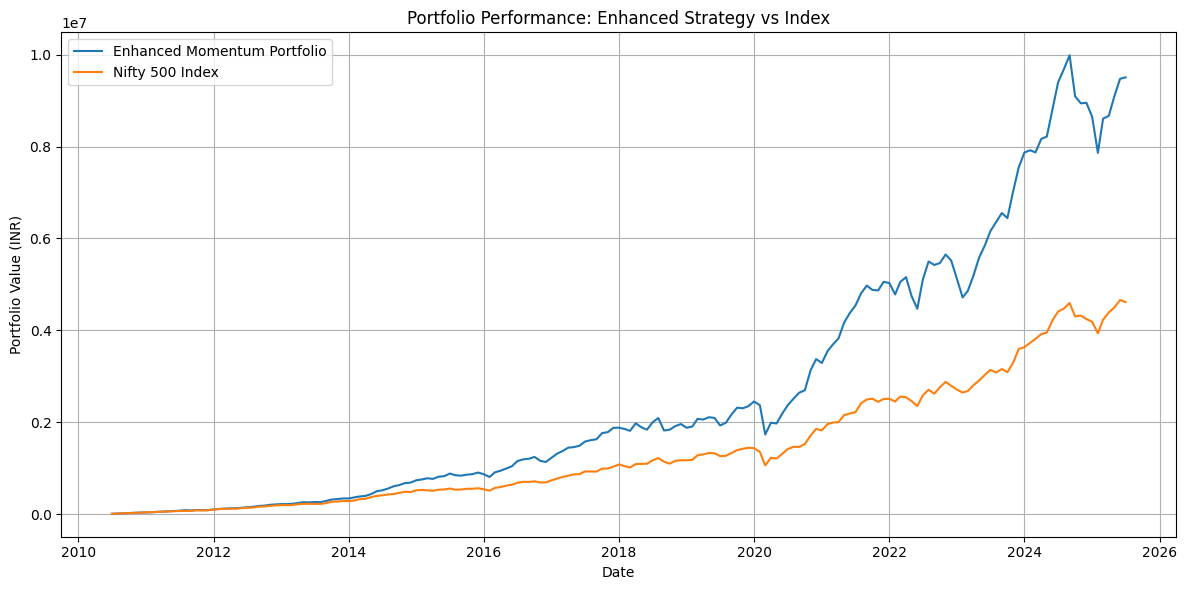

Strategy return multiplier: 2.06x over index


In [3672]:
# import yfinance as yf
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt

# -----------------------------
# SETUP
# -----------------------------
tickers = NIFTY_500.columns.tolist() # Nifty 500 tickers
nifty500_ticker = "^CNX100"  # Or other proxy
start_date = "2010-01-01"
monthly_investment = 5000
top_n = 5
momentum_lookback = 6  # months
volatility_lookback = 6

# -----------------------------
# DOWNLOAD DATA
# -----------------------------
# data = yf.download(tickers + [nifty500_ticker], start=start_date, interval="1mo", auto_adjust=True)['Close']
# volume_data = yf.download(tickers, start=start_date, interval="1mo", auto_adjust=False)['Volume']

# Clean
# data = data.dropna(thresh=int(0.3 * len(data.columns)))
volume_data = volume_data.reindex(data.index).fillna(0)

stock_data = data.drop(columns=[nifty500_ticker])
index_data = data[nifty500_ticker]

# -----------------------------
# SIMULATION
# -----------------------------
portfolio_units = {}
index_units = 0
momentum_values, index_values, dates = [], [], []

for i in range(momentum_lookback, len(stock_data)):
    
    monthly_investment = int(monthly_investment*(1.008))
    
    date = stock_data.index[i]
    prev_date = stock_data.index[i - momentum_lookback]

    # Momentum: 6-month return
    momentum_returns = (stock_data.loc[date] / stock_data.loc[prev_date]) - 1

    # Volatility: Std dev of monthly returns over past 6 months
    volatility = stock_data.iloc[i - volatility_lookback:i].pct_change(fill_method=None).std()

    # Liquidity: Average volume
    avg_volume = volume_data.iloc[i - volatility_lookback:i].mean()

    # Filter: Drop high-volatility, low-volume stocks
    combined = pd.DataFrame({
        'return': momentum_returns,
        'volatility': volatility,
        'volume': avg_volume
    }).dropna()

    filtered = combined[
        (combined['volatility'] < combined['volatility'].median()) &
        (combined['volume'] > combined['volume'].median())
    ]

    top_stocks = filtered.sort_values('return', ascending=False).head(top_n).index

    # Buy ₹1000 of each top stock
    for stock in top_stocks:
        price = stock_data.loc[date, stock]
        if pd.notna(price):
            qty = (monthly_investment/top_n) / price
            portfolio_units[stock] = portfolio_units.get(stock, 0) + qty

    # Index investment
    index_price = index_data.loc[date]
    if pd.notna(index_price):
        index_units += monthly_investment / index_price

    # Portfolio values
    port_val = sum(
        portfolio_units[stk] * stock_data.loc[date, stk]
        for stk in portfolio_units
        if pd.notna(stock_data.loc[date, stk])
    )
    index_val = index_units * index_price

    dates.append(date)
    momentum_values.append(port_val)
    index_values.append(index_val)

# -----------------------------
# RESULTS
# -----------------------------
plt.figure(figsize=(12, 6))
plt.plot(dates, momentum_values, label="Enhanced Momentum Portfolio")
plt.plot(dates, index_values, label="Nifty 500 Index")
plt.title("Portfolio Performance: Enhanced Strategy vs Index")
plt.xlabel("Date")
plt.ylabel("Portfolio Value (INR)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Return comparison
final_momentum = momentum_values[-1]
final_index = index_values[-1]
print(f"Strategy return multiplier: {(final_momentum/final_index):.2f}x over index")


Strategy return multiplier: 2.69x over index


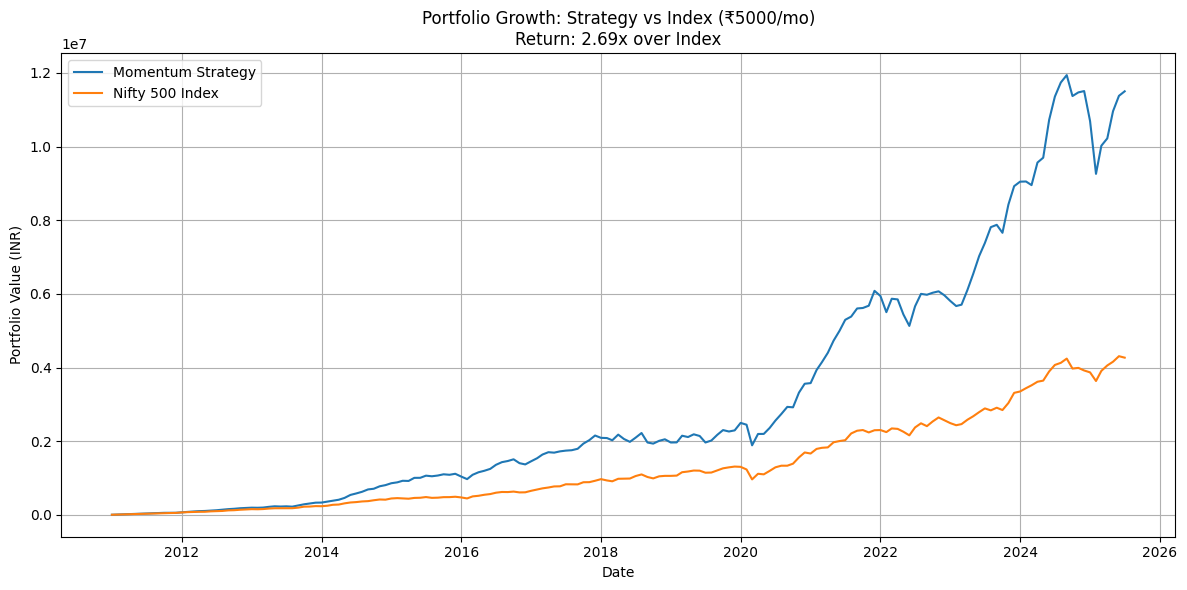

In [3673]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# CONFIGURATION
# -----------------------------
tickers = [...]  # Add your list of Nifty 500 stock symbols here
index_ticker = "^CRSLDX"  # Nifty 500 Index
start_date = "2010-01-01"
monthly_investment = 5000
top_n = 10

# -----------------------------
# DOWNLOAD DATA
# -----------------------------
# data = yf.download(tickers + [index_ticker], start=start_date, interval="1mo", auto_adjust=True)['Close']
# data = data.dropna(thresh=len(data.columns) * 0.8)

# # Separate index and stock data
# index_data = data[index_ticker]
# stock_data = data.drop(columns=[index_ticker])

# -----------------------------
# SIMULATION
# -----------------------------
momentum_portfolio = {}
index_units = 0
dates, strategy_values, index_values = [], [], []

for i in range(12, len(stock_data)):  # start after 12 months for momentum calc
    monthly_investment = int(monthly_investment*(1.008))
    
    date = stock_data.index[i]
    prev_1 = stock_data.index[i - 1]
    prev_3 = stock_data.index[i - 3]
    prev_6 = stock_data.index[i - 6]
    prev_12 = stock_data.index[i - 12]

    current_prices = stock_data.loc[date]
    m3 = stock_data.loc[prev_1] / stock_data.loc[prev_3] - 1
    m6 = stock_data.loc[prev_1] / stock_data.loc[prev_6] - 1
    m12 = stock_data.loc[prev_1] / stock_data.loc[prev_12] - 1
    momentum_score = 0.5 * m3 + 0.3 * m6 + 0.5 * m12

    # Trend filter: price > 200-day SMA (approx 10-month SMA)
    trend = stock_data.rolling(window=10).mean().loc[date]
    trending = current_prices > trend

    # Liquidity filter: avg price over last 3 months
    avg_price = stock_data.iloc[i-3:i].mean()
    liquid = avg_price > 10  # you can adjust threshold

    # Volatility filter: lowest std dev of returns
    volatility = stock_data.pct_change(fill_method=None).rolling(window=3).std().iloc[i - 1]
    low_volatility = volatility.nsmallest(len(stock_data.columns)//2).index

    # Combine filters
    filtered = momentum_score.dropna()
    filtered = filtered[trending & liquid]
    filtered = filtered[filtered.index.isin(low_volatility)]

    top_stocks = filtered.sort_values(ascending=False).head(top_n).index

    # Buy top stocks equally with ₹5000
    for stock in top_stocks:
        price = current_prices[stock]
        if pd.notna(price) and price > 0:
            qty = (monthly_investment / top_n) / price
            momentum_portfolio[stock] = momentum_portfolio.get(stock, 0) + qty

    # Buy index with ₹5000
    index_price = index_data.loc[date]
    if pd.notna(index_price) and index_price > 0:
        index_units += monthly_investment / index_price

    # Portfolio value
    value = sum(momentum_portfolio[stk] * current_prices[stk]
                for stk in momentum_portfolio if pd.notna(current_prices[stk]))
    strategy_values.append(value)
    index_values.append(index_units * index_price)
    dates.append(date)

# -----------------------------
# RESULTS
# -----------------------------
multiplier = round(strategy_values[-1] / index_values[-1], 2)
print(f"Strategy return multiplier: {multiplier}x over index")

plt.figure(figsize=(12, 6))
plt.plot(dates, strategy_values, label="Momentum Strategy")
plt.plot(dates, index_values, label="Nifty 500 Index")
plt.title(f"Portfolio Growth: Strategy vs Index (₹5000/mo)\nReturn: {multiplier}x over Index")
plt.xlabel("Date")
plt.ylabel("Portfolio Value (INR)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Data load

In [192]:
# # First time data download and ingest into gsheet, later load data from gsheet without downloading again.

# import yfinance as yf
# import pandas as pd
# import os
# # pd.set_option('display.max_rows', None)
# # pd.set_option("display.max_columns", None)

# https://www.niftyindices.com/indices/equity/broad-based-indices/niftysmallcap250

# import pygsheets
# gc = pygsheets.authorize(service_file=r"C:\Users\mayan\Downloads\gsheet_api_key.json")
# # gsheetaccess@my-project-to-link-gsheet.iam.gserviceaccount.com
# url = "https://docs.google.com/spreadsheets/d/1_j6EMNZoXLIBjOtj7ifpo3qb9MZ_EuwIeZ2jFfUJZfQ/edit?gid=0#gid=0"
# gsheet = gc.open_by_url(url)
# tab = 'Tickers'
# hop = gsheet.worksheet('title',tab)
# df = hop.get_as_df()

# tickers = df['Symbol'].copy()
# tickers = [i+".NS" for i in tickers]
# data_full = yf.download(tickers, start="2001-01-01", interval="1d", auto_adjust=True)['Close']
# data_full = data_full.ffill().round(2)

# import pygsheets
# gc = pygsheets.authorize(service_file=r"C:\Users\mayan\Downloads\gsheet_api_key.json")
# # gsheetaccess@my-project-to-link-gsheet.iam.gserviceaccount.com
# url = "https://docs.google.com/spreadsheets/d/1_j6EMNZoXLIBjOtj7ifpo3qb9MZ_EuwIeZ2jFfUJZfQ/edit?gid=0#gid=0"
# gsheet = gc.open_by_url(url)
# data = data_full.reset_index().copy()
# tab = 'data_full'
# hop = gsheet.worksheet('title', tab)
# hop.clear('A1', 'Z1000000')
# hop.set_dataframe(data, 'A1', copy_index=False, fit=True)

[*********************100%***********************]  500 of 500 completed


In [293]:
# Load data from gsheet

import yfinance as yf
import pandas as pd
import os
pd.set_option('display.max_rows', None)
pd.set_option("display.max_columns", None)

import pygsheets
gc = pygsheets.authorize(service_file=r"C:\Users\mayan\Downloads\gsheet_api_key.json")
# gsheetaccess@my-project-to-link-gsheet.iam.gserviceaccount.com
url = "https://docs.google.com/spreadsheets/d/1_j6EMNZoXLIBjOtj7ifpo3qb9MZ_EuwIeZ2jFfUJZfQ/edit?gid=0#gid=0"
gsheet = gc.open_by_url(url)
tab = 'data_full'
hop = gsheet.worksheet('title',tab)
data_full = hop.get_as_df()

# Assign first column as Index
data_full.set_index(data_full.columns[0], inplace=True)
# Ensure index is datetime
data_full.index = pd.to_datetime(data_full.index)

### Pct Diff

In [905]:
# set everything before the minimum price index up and 300 rows after it to NaN
def align_from_min(s):
    i = s.idxmin()
    pos = s.index.get_loc(i)
    s.iloc[:pos+300] = np.nan
    return s.ffill()
df = data_full.copy()
data_aligned = df.apply(align_from_min)

# Make a dataframe to get day-on-day pct_change
df = data_aligned.copy()
df_return = df.pct_change(fill_method=None).replace([np.inf, -np.inf], np.nan)

# set everything before the last row where df_return > 20% or < -20% in a day to NaN
def set_before_last_extreme(s):
    mask = (s > 0.3) | (s < -0.3)        # because of divident adjust or split price might be hiked # because of covid stock might carshed # So ignore this function
    if mask.any():
        first_idx = mask.idxmax()        # get index of first True
        last_idx = mask[mask].index[-1]  # get index of last True
        s[:last_idx] = np.nan
    return s
# df_return = df_return.apply(set_before_last_extreme)        # Don't use it

In [906]:
# set leading zeros at the beginning of each column to NaN
df_return = df_return.mask(df_return.cummax() == 0, np.nan)

In [ ]:
# 6000 ka 25% nikalna hai
# 6000/25 karne se better hai 60* 100/25 karna. or 6000*4/100

In [907]:
# Drop the new stocks
# Drop columns where the value at index -1000 from the end is NaN
df_return = df_return.loc[:, df_return.iloc[-1500].notna()]
df_return.shape

(6172, 309)

In [908]:
# Drop the volatile stocks
# Keep only columns where count of extreme values (>|0.2|) is <= 10
df_filtered = df_return.loc[:, ((df_return > 0.2) | (df_return < -0.2)).sum() <= 10]

In [917]:
# Drop the volatile stocks
# Keep only columns where count of extreme values (>|0.2|) is <= 10
volatile_stocks = df_return.loc[:, (((df_return > 0.2).sum() >= 10) | ((df_return < -0.1).sum() >= 20))].columns
volatile_stocks
# Check karna ki ye stocks final buy recommendation me aa rahe hain kya, yadi ha to fir strategy gadbad hai.

Index(['ABREL.NS', 'ADANIENT.NS', 'BALRAMCHIN.NS', 'BANKINDIA.NS', 'BSOFT.NS',
       'CGPOWER.NS', 'CHAMBLFERT.NS', 'CHENNPETRO.NS', 'HEG.NS', 'IDBI.NS',
       'IFCI.NS', 'IIFL.NS', 'INDUSINDBK.NS', 'ITI.NS', 'JBMA.NS',
       'JINDALSAW.NS', 'JINDALSTEL.NS', 'JSWSTEEL.NS', 'MRPL.NS', 'NCC.NS',
       'POONAWALLA.NS', 'SAIL.NS', 'SRF.NS', 'TATASTEEL.NS', 'VEDL.NS',
       'WELCORP.NS', 'YESBANK.NS', 'ZEEL.NS'],
      dtype='object')

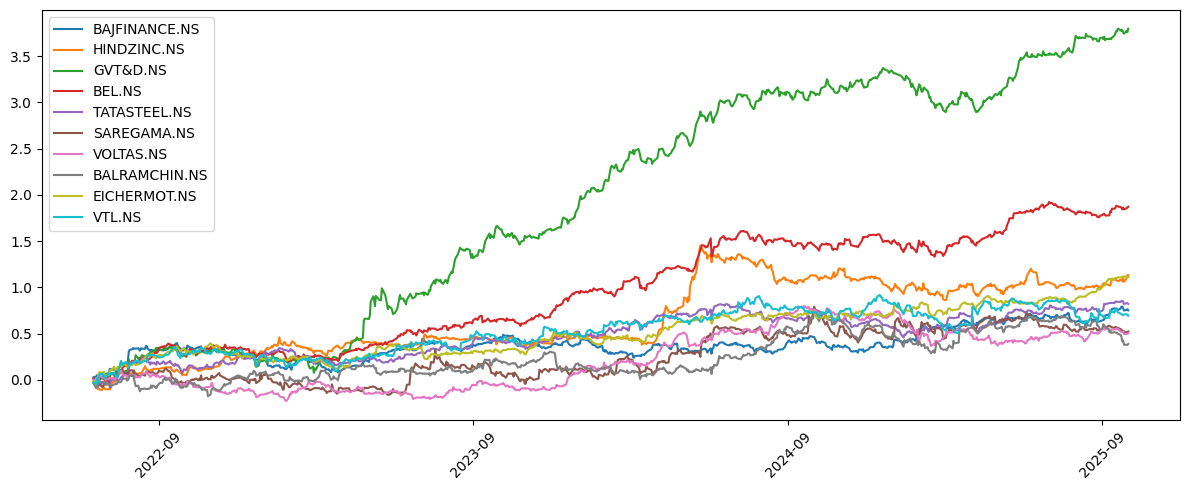

In [912]:
# cumulative addition of return

# Ensure index is datetime
# df.index = pd.to_datetime(df.index)

stocks = df_filtered.loc[:'2022-06-17',:].mean(axis=0).sort_values(ascending=False).head(10).index
df = df_filtered.loc['2022-06-17':,stocks].cumsum()

plt.figure(figsize=(12,5))
plt.plot(df)

# add legend for stock names
plt.legend(stocks, loc="best")

# Rotate x-axis labels and format
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=12))  # every 3 months
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.tight_layout()
plt.show()


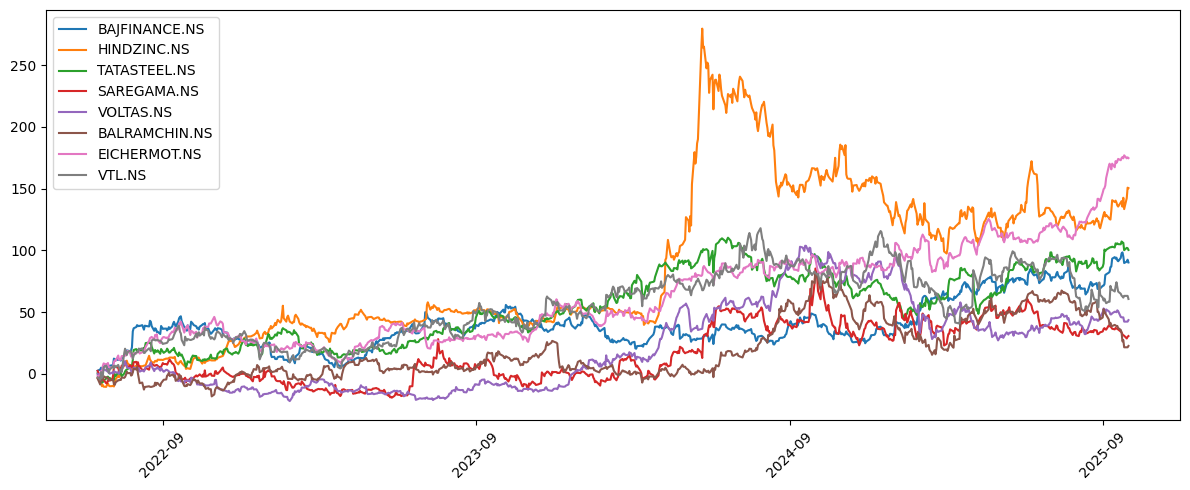

In [920]:
# cumulative compounding return over time

# Ensure index is datetime
# df.index = pd.to_datetime(df.index)

stocks = df_filtered.loc[:'2022-06-17',:].mean(axis=0).sort_values(ascending=False).head(10).index.drop(['GVT&D.NS','BEL.NS'])
df = ((1 + df_filtered.loc['2022-06-17':,stocks]).cumprod()-1)*100

plt.figure(figsize=(12,5))
plt.plot(df)

# add legend for stock names
plt.legend(stocks, loc="best")

# Rotate x-axis labels and format
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=12))  # every 3 months
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.tight_layout()
plt.show()


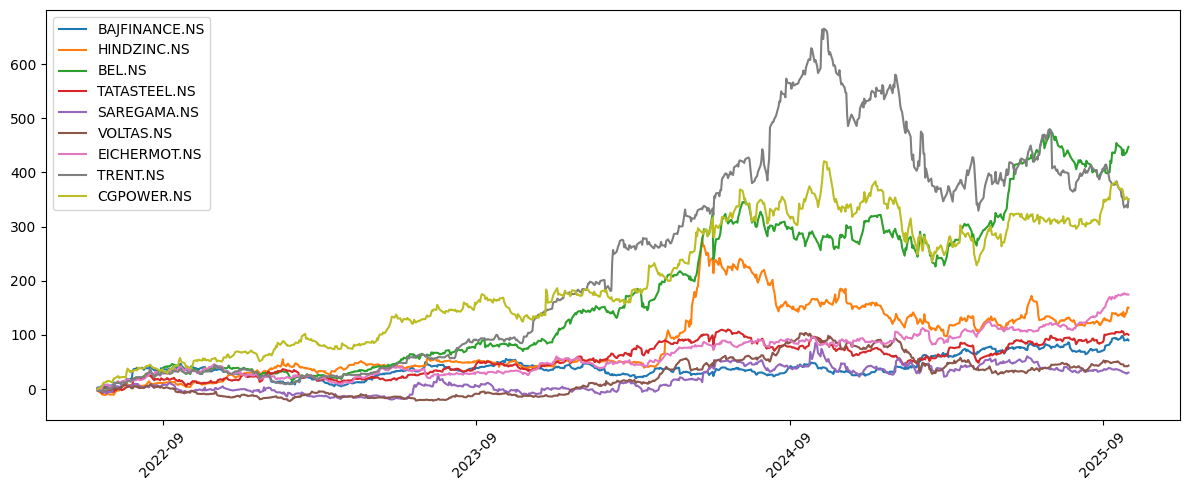

In [923]:
# Recommendation to buy

stocks = df_filtered.loc[:,:].mean(axis=0).sort_values(ascending=False).head(10).index.drop(['GVT&D.NS'])
df = ((1 + df_filtered.loc['2022-06-17':,stocks]).cumprod()-1)*100

plt.figure(figsize=(12,5))
plt.plot(df)

# add legend for stock names
plt.legend(stocks, loc="best")

# Rotate x-axis labels and format
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=12))  # every 3 months
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.tight_layout()
plt.show()


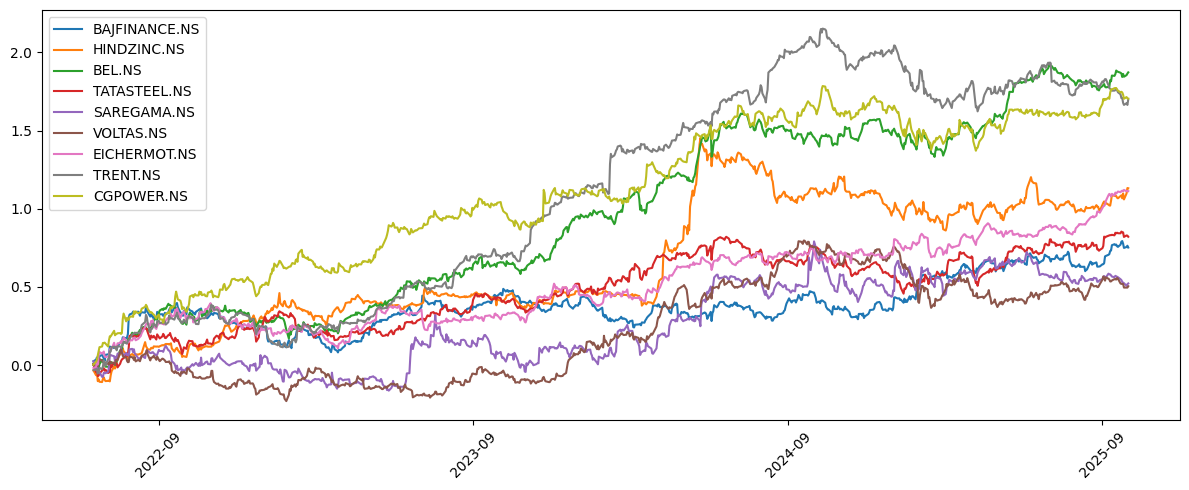

In [924]:
# Recommendation to buy

stocks = df_filtered.loc[:,:].mean(axis=0).sort_values(ascending=False).head(10).index.drop(['GVT&D.NS'])
df = df_filtered.loc['2022-06-17':,stocks].cumsum()

plt.figure(figsize=(12,5))
plt.plot(df)

# add legend for stock names
plt.legend(stocks, loc="best")

# Rotate x-axis labels and format
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=12))  # every 3 months
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.tight_layout()
plt.show()

In [ ]:
# Insights (based on Grok AI)

# HINDZINC - Don't buy - as it faces cyclical risks from commodities
# TATASTEEL - Don't buy - as it is cyclical in steel sector
# SAREGAMA - Don't buy - as recently net profit declines and negative longterm forcast
# VOLTUS - Don't buy - as low ROE
